使用許諾条件

①	設計一次エネルギー消費量算定法に基づく計算方法をPythonによりコーディングし、Jupyter notebook形式で保存したファイル（以下、本ファイルと呼ぶ）の著作権は、一般社団法人日本サステナブル建築協会に帰属します。
Copyright©2019. 一般社団法人日本サステナブル建築協会
All rights reserved. 

②	本ファイルは、住戸の設計一次エネルギー消費量算定方法に係る「平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）2.1算定方法（第六章 照明設備）」に示す計算方法に基づき、国土交通省国土技術政策総合研究所・国立研究開発法人建築研究所、株式会社ユーワークス、株式会社住環境計画研究所が作成したものです。

③	本ファイルは、計算方法に示す計算過程の確認及び調査研究等に活用することを目的として作成されたものであり、一般社団法人日本サステナブル建築協会は著作権について放棄はしませんが、使用する各人の自己責任において仕様を変更することを妨げるものではありません。ただし、本ファイルによる計算結果を住宅の省エネルギー基準で規定する設計一次エネルギー消費量の結果として公的な申請に用いることはできません。

④	本ファイルを変更するかしないかを問わず、以下の条件を満たす場合に限り、頒布および使用が許可されます。
1.	頒布物の付属ドキュメント等の資料に、上記の著作権表示、本条件一覧、および下記免責条項を含めること。
2.	書面による特別の許可なしに、本ファイルから派生した製品の宣伝または販売の促進に、一般社団法人日本サステナブル建築協会、国土技術政策総合研究所・国立研究開発法人建築研究所および株式会社ユーワークス、株式会社住環境計画研究所の名前またはコントリビューターの名前を使用してはならない。

⑤	本ファイルは、著作権者およびコントリビューターによって「現状のまま」提供されており、明示黙示を問わず、商業的な使用可能性、および特定の目的に対する適合性に関する暗黙の保証も含め、またそれに限定されない、いかなる保証もありません。著作権もコントリビューターも、事由のいかんを問わず、損害発生の原因いかんを問わず、かつ責任の根拠が契約であるか厳格責任であるか（過失その他の）不法行為であるかを問わず、仮にそのような損害が発生する可能性を知らされていたとしても、本ファイルの使用によって発生した（代用品または代用サービスの調達、使用の喪失、データの喪失、利益の喪失、業務の中断も含め、またそれに限定されない）直接損害、間接損害、偶発的な損害、特別損害、懲罰的損害、または結果損害について、一切の責任を負わないものとします。



In [1]:
import nbimporter
import numpy as np
from functools import lru_cache

import matplotlib.pyplot as plt
%matplotlib inline

from s11_03_life_schedule import load_schedule, get_schedule_l

Importing Jupyter notebook from s11_03_life_schedule.ipynb


# 第六章　照明設備 / Chapter 6 Lighting

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

## 5．照明設備の消費電力量 / Power consumption of lighting equipment

その他居室が無い場合は$E_{E,L,OR,d,t}$を 0 とする。非居室が無い場合は$E_{E,L,NO,d,t}$を 0 とする。 

If there are no other rooms, $ E_ {E, L, OR, d, t} $ is set to 0. If there is no living room, $ E_ {E, L, NO, d, t} $ is set to 0.

$$
E_{E,L,d,t} = E_{E,L,MR,d,t} + E_{E,L,OR,d,t} + E_{E,L,NO,d,t}
$$

$E_{E,L,d,t}$：日付$d$の時刻$t$における1 時間当たりの照明設備の消費電力量(kWh/h) / Power consumption per hour of lighting fixture at time $ t $ on date $ d $  
$E_{E,L,MR,d,t}$：日付$d$の時刻$t$における1 時間当たりの主たる居室の照明設備の消費電力量(kWh/h) / Power consumption per hour of the main room's lighting fixtures at time $ t $ on date $ d $  
$E_{E,L,OR,d,t}$：日付$d$の時刻$t$における1 時間当たりのその他の居室の照明設備の消費電力量(kWh/h) / Power consumption per hour of other room lighting fixtures at time $ t $ on date $ d $  
$E_{E,L,NO,d,t}$：日付$d$の時刻$t$における1 時間当たりの非居室の照明設備の消費電力量(kWh/h) / Power consumption per hour of non-residential lighting fixtures at time $ t $ on date $ d $

In [2]:
def calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L):
    """1 時間当たりの照明設備の消費電力量（kWh/h）

    :param n_p: 仮想居住人数
    :type n_p: float
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param L: 照明設備仕様辞書
    :type L: dict
    :return: E_E_L_d_t 日付dの時刻tにおける 1 時間当たりの照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """

    if L is None:
        return np.zeros(24*365)

    def get_value(key):
        return L[key] if key in L else None

    # 1時間当たりの居住人数がp人における主たる居室の照明設備の消費電力量
    E_E_L_MR_d_t = calc_E_E_L_MR_d_t(
        n_p=n_p,
        A_A=A_A,
        A_MR=A_MR,
        A_OR=A_OR,
        MR_installed=get_value('MR_installed'),
        MR_power=get_value('MR_power'),
        MR_multi=get_value('MR_multi'),
        MR_dimming=get_value('MR_dimming')
    )

    # 1時間当たりの居住人数がp人におけるその他の居室の照明設備の消費電力量
    if L['has_OR']:
        E_E_L_OR_d_t = calc_E_E_L_OR_d_t(
            n_p=n_p,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            OR_installed=get_value('OR_installed'),
            OR_power=get_value('OR_power'),
            OR_dimming=get_value('OR_dimming')
        )
    else:
        E_E_L_OR_d_t = np.zeros(24 * 365)

    # 1時間当たりの居住人数がp人における非居室の照明設備の消費電力量
    if L['has_NO']:
        E_E_L_NO_d_t = calc_E_E_L_NO_d_t(
            n_p=n_p,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            NO_installed=get_value('NO_installed'),
            NO_power=get_value('NO_power'),
            NO_sensor=get_value('NO_sensor')
        )
    else:
        E_E_L_NO_d_t = np.zeros(24 * 365)

    return E_E_L_MR_d_t + E_E_L_OR_d_t + E_E_L_NO_d_t  # (1)


### 5.1　主たる居室 / Main room

$$
\displaystyle
E_{E,L,MR,d,t} = \left\{ \begin{array}{ll}
    E_{E,L,MR,p,d,t}|_{p=1} \times \frac{2 - n_p}{2 - 1} +  E_{E,L,MR,p,d,t}|_{p=2} \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    E_{E,L,MR,p,d,t}|_{p=2} \times \frac{3 - n_p}{3 - 2} +  E_{E,L,MR,p,d,t}|_{p=3} \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    E_{E,L,MR,p,d,t}|_{p=3} \times \frac{4 - n_p}{4 - 3} +  E_{E,L,MR,p,d,t}|_{p=4} \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$

$E_{E,L,MR,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人における主たる居室の照明設備の消費電力量(kWh/h) / The hourly power consumption of the light fixtures in the main living room with $ p $ people living at $ t $ on a $ d $ date  
$n_p$：仮想居住人数 / Virtual number of people

In [3]:
def calc_E_E_L_MR_d_t(n_p, A_A, A_MR, A_OR, MR_installed, MR_power=None, MR_multi=None, MR_dimming=None):
    """1 時間当たりの居住人数がp人における主たる居室の照明設備の消費電力量（kWh/h）

    :param n_p: 仮想居住人数
    :type n_p: float
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param MR_installed: 主たる居室の設置
    :type MR_installed: str
    :param MR_power: 主たる居室の照明器具の種類
    :type MR_power: str
    :param MR_multi: 主たる居室の多灯分散照明方式の採用
    :type MR_multi: str
    :param MR_dimming: 主たる居室の調光が可能な制御の採用
    :type MR_dimming: str
    :return:　E_E_L_MR_d_t　：日付dの時刻tにおける 1 時間当たりの居住人数がp人における主たる居室の照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """
    # (2)
    if 1 <= n_p and n_p <= 2:
        E_E_L_MR_1_d_t = calc_E_E_L_MR_p_d_t(1, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming)
        E_E_L_MR_2_d_t = calc_E_E_L_MR_p_d_t(2, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming)
        return E_E_L_MR_1_d_t * (2 - n_p) / (2 - 1) + E_E_L_MR_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        E_E_L_MR_2_d_t = calc_E_E_L_MR_p_d_t(2, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming)
        E_E_L_MR_3_d_t = calc_E_E_L_MR_p_d_t(3, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming)
        return E_E_L_MR_2_d_t * (3 - n_p) / (3 - 2) + E_E_L_MR_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        E_E_L_MR_3_d_t = calc_E_E_L_MR_p_d_t(3, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming)
        E_E_L_MR_4_d_t = calc_E_E_L_MR_p_d_t(4, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming)
        return E_E_L_MR_3_d_t * (4 - n_p) / (4 - 3) + E_E_L_MR_4_d_t * (n_p - 3) / (4 - 3)


$$
E_{E,L,MR,p,d,t} = \sum_{i = 1\sim3} E_{E,L,i,p,d,t}
$$

$E_{E,L,i,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人における照明区画$i$に設置された照明設備の消費電力量(kWh/h) / The hourly power consumption of the lighting fixtures installed in the lighting section $ i $ with $ p $ people living at the time $ t $ of the date $ d $

In [4]:
def calc_E_E_L_MR_p_d_t(p, A_A, A_MR, A_OR, MR_installed, MR_power, MR_multi, MR_dimming):
    """1 時間当たりの居住人数がp人における主たる居室の照明設備の消費電力量（kWh/h）

    :param p: 居住人数
    :type p: int
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param MR_installed: 主たる居室の設置
    :type MR_installed: str
    :param MR_power: 主たる居室の照明器具の種類
    :type MR_power: str
    :param MR_multi: 主たる居室の多灯分散照明方式の採用
    :type MR_multi: str
    :param MR_dimming: 主たる居室の調光が可能な制御の採用
    :type MR_dimming: str
    :return: E_E_L_MR_p_d_t 日付dの時刻tにおける 1 時間当たりの居住人数がp人における主たる居室の照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """
    E_E_L_i_p_d_t = np.zeros((3, 24 * 365))
    for i in range(1, 4):
        E_E_L_i_p_d_t[i - 1] = calc_E_E_L_i_p_d_t(i, p, A_A, A_MR, A_OR, MR_installed, MR_power,
                                                  MR_multi, MR_dimming)
    # (3)
    E_E_L_MR_p_d_t = np.sum(E_E_L_i_p_d_t, axis=0)

    return E_E_L_MR_p_d_t


### 5.2　その他の居室 / Other rooms

$$
\displaystyle
E_{E,L,OR,d,t} = \left\{ \begin{array}{ll}
    E_{E,L,OR,p,d,t}|_{p=1} \times \frac{2 - n_p}{2 - 1} +  E_{E,L,OR,p,d,t}|_{p=2} \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    E_{E,L,OR,p,d,t}|_{p=2} \times \frac{3 - n_p}{3 - 2} +  E_{E,L,OR,p,d,t}|_{p=3} \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    E_{E,L,OR,p,d,t}|_{p=3} \times \frac{4 - n_p}{4 - 3} +  E_{E,L,OR,p,d,t}|_{p=4} \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$

$E_{E,L,OR,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人におけるその他の居室の照明設備の消費電力量(kWh/h) / The hourly power consumption of the lighting equipment of other rooms with $ p $ people living at the time $ t $ of the date $ d $   
$n_p$：仮想居住人数 / Virtual number of people

In [5]:
def calc_E_E_L_OR_d_t(n_p, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming):
    """1 時間当たりの居住人数がp人におけるその他の居室の照明設備の消費電力量（kWh/h）

    :param n_p: 仮想居住人数
    :type n_p: float
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param OR_installed: その他の居室の設置
    :type OR_installed: str
    :param OR_power: その他の居室の照明器具の種類
    :type OR_power: str
    :param OR_dimming: その他の居室の調光が可能な制御の採用
    :type OR_dimming: str
    :return:　E_E_L_OR_d_t 日付dの時刻ｔにおける 1 時間当たりのその他の居室の照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """
    # (4)
    if 1 <= n_p and n_p <= 2:
        E_E_L_OR_1_d_t = calc_E_E_L_OR_p_d_t(1, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming)
        E_E_L_OR_2_d_t = calc_E_E_L_OR_p_d_t(2, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming)
        return E_E_L_OR_1_d_t * (2 - n_p) / (2 - 1) + E_E_L_OR_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        E_E_L_OR_2_d_t = calc_E_E_L_OR_p_d_t(2, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming)
        E_E_L_OR_3_d_t = calc_E_E_L_OR_p_d_t(3, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming)
        return E_E_L_OR_2_d_t * (3 - n_p) / (3 - 2) + E_E_L_OR_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        E_E_L_OR_3_d_t = calc_E_E_L_OR_p_d_t(3, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming)
        E_E_L_OR_4_d_t = calc_E_E_L_OR_p_d_t(4, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming)
        return E_E_L_OR_3_d_t * (4 - n_p) / (4 - 3) + E_E_L_OR_4_d_t * (n_p - 3) / (4 - 3)


$$
E_{E,L,OR,p,d,t} = \sum_{i = 4\sim7} E_{E,L,i,p,d,t}
$$

$E_{E,L,i,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人における照明区画$i$に設置された照明設備の消費電力量(kWh/h) / The hourly power consumption of the lighting fixtures installed in the lighting section $ i $ with $ p $ people living at the time $ t $ of the date $ d $

In [6]:
def calc_E_E_L_OR_p_d_t(p, A_A, A_MR, A_OR, OR_installed, OR_power, OR_dimming):
    """ 1 時間当たりの居住人数がp人におけるその他の居室の照明設備の消費電力量（kWh/h）

    :param p: 居住人巣
    :type p: int
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param OR_installed: その他の居室の設置
    :type OR_installed: str
    :param OR_power: その他の居室の照明器具の種類
    :type OR_power: str
    :param OR_dimming: その他の居室の調光が可能な制御の採用
    :type OR_dimming: str
    :return: E_E_L_OR_p_d_t 日付dの時刻tにおける 1 時間当たりの居住人数がp人におけるその他の居室の照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """
    E_E_L_i_p_d_t = np.zeros((4, 24 * 365))
    for i in range(4, 8):
        E_E_L_i_p_d_t[i - 4] = calc_E_E_L_i_p_d_t(i, p, A_A, A_MR, A_OR, OR_installed=OR_installed, OR_power=OR_power,
                                                  OR_dimming=OR_dimming)

    # (5)
    E_E_L_OR_p_d_t = np.sum(E_E_L_i_p_d_t, axis=0)

    return E_E_L_OR_p_d_t


### 5.3　非居室 / No living room

$$
\displaystyle
E_{E,L,NO,d,t} = \left\{ \begin{array}{ll}
    E_{E,L,NO,p,d,t}|_{p=1} \times \frac{2 - n_p}{2 - 1} +  E_{E,L,NO,p,d,t}|_{p=2} \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2)\\ 
    E_{E,L,NO,p,d,t}|_{p=2} \times \frac{3 - n_p}{3 - 2} +  E_{E,L,NO,p,d,t}|_{p=3} \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\ 
    E_{E,L,NO,p,d,t}|_{p=3} \times \frac{4 - n_p}{4 - 3} +  E_{E,L,NO,p,d,t}|_{p=4} \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)\\ 
    \end{array}
\right.
$$

$E_{E,L,NO,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人における非居室の照明設備の消費電力量(kWh/h) / The hourly power consumption of the non-residential room lighting fixtures with $ p $ people living at the time $ t $ of the date $ d $  
$n_p$：仮想居住人数 / Virtual number of people

In [7]:
def calc_E_E_L_NO_d_t(n_p, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor):
    """1 時間当たりの非居室の照明設備の消費電力量（kWh/h）

    :param n_p: 仮想居住人数
    :type n_p: float
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_power: 非居室の照明器具の種類
    :type NO_power: str
    :param NO_sensor: 非居室の人感センサーの採用
    :type NO_sensor: str
    :return: E_E_L_NO_d_t 日付dの時刻tにおける 1 時間当たりの非居室の照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """
    # (6)
    if 1 <= n_p and n_p <= 2:
        E_E_L_NO_1_d_t = calc_E_E_L_NO_p_d_t(1, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor)
        E_E_L_NO_2_d_t = calc_E_E_L_NO_p_d_t(2, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor)
        return E_E_L_NO_1_d_t * (2 - n_p) / (2 - 1) + E_E_L_NO_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        E_E_L_NO_2_d_t = calc_E_E_L_NO_p_d_t(2, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor)
        E_E_L_NO_3_d_t = calc_E_E_L_NO_p_d_t(3, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor)
        return E_E_L_NO_2_d_t * (3 - n_p) / (3 - 2) + E_E_L_NO_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        E_E_L_NO_3_d_t = calc_E_E_L_NO_p_d_t(3, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor)
        E_E_L_NO_4_d_t = calc_E_E_L_NO_p_d_t(4, A_A, A_MR, A_OR, NO_installed, NO_power, NO_sensor)
        return E_E_L_NO_3_d_t * (4 - n_p) / (4 - 3) + E_E_L_NO_4_d_t * (n_p - 3) / (4 - 3)


$$
E_{E,L,NO,p,d,t} = \sum_{i = 8\sim18} E_{E,L,i,p,d,t} + E_{E,L,port,p,d,t}
$$

$E_{E,L,i,p,d,t}$：日付$d$の時刻$t$における 1 時間当たりの居住人数が$p$人における照明区画$i$に設置された照明設備の消費電力量(kWh/h) / The power consumption per hour of the lighting equipment installed in the lighting section $ i $ with $ p $ people living at the time $ t $ of the date $ d $  
$E_{E,L,port,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人における玄関ポーチに設置された照明設備の消費電力量(kWh/h) / The hourly power consumption of the lighting equipment installed on the entrance porch with $ p $ people living at the time $ t $ of the date $ d $ 

In [8]:
def calc_E_E_L_NO_p_d_t(p, A_A, A_MR, A_OR, NO_installed, NO_power=None, NO_sensor=None):
    """1 時間当たりの居住人数がp人における非居室の照明設備の消費電力量（kWh/h）

    :param p: 居住人数
    :type p: int
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_power: 非居室の照明器具の種類
    :type NO_power: str
    :param NO_sensor: 非居室の人感センサーの採用
    :type NO_sensor: str
    :return: E_E_L_NO_p_d_t 日付dの時刻tにおける 1 時間当たりの居住人数がp人における非居室の照明設備の消費電力量[kWh/h]
    :rtype: ndarray
    """
    E_E_L_i_p_d_t = np.zeros((11, 24 * 365))
    for i in range(8, 19):
        E_E_L_i_p_d_t[i - 8] = calc_E_E_L_i_p_d_t(i, p, A_A, A_MR, A_OR, NO_installed=NO_installed, NO_power=NO_power,
                                                  NO_sensor=NO_sensor)

    E_E_L_port_p_d_t = calc_E_E_L_port_p_d_t(p, NO_installed, NO_power, NO_sensor)
    # (7)
    E_E_L_NO_p_d_t = np.sum(E_E_L_i_p_d_t, axis=0) + E_E_L_port_p_d_t
    return E_E_L_NO_p_d_t


## 6．照明区画に設置された照明設備 / Lighting equipment installed in the lighting area

### 6.1　消費電力量 / Power consumption

$$
E_{E,L,i,p,d,t} = (F_i \div Le_i \times Ce_i) \times Cd_i \times Cs_i \times Cm_i \times Ci_i \times 10^{-3} \times r_{i,p,d,t}
$$

$E_{E,L,i,p,d,t}$：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における照明区画$i$に設置された照明設備の消費電力量(kWh/h) / The power consumption per hour of the lighting equipment installed in the lighting section $ i $ with $ p $ people living at the time $ t $ of the date $ d $  
$F_i$：照明区画$i$における室内光束(lm) / Room luminous flux in the lighting section $ i $  
$Le_i$：照明区画$i$に設置された照明設備の平均総合効率(lm/W) / Average overall efficiency of lighting installed in lighting section $ i $  
$Ce_i$：照明区画$i$に設置された照明設備の特殊条件による補正係数 / Correction factor due to special conditions of lighting equipment installed in lighting section $ i $  
$Cd_i$：照明区画$i$に設置された照明設備の調光による補正係数 / Correction factor by dimming of lighting equipment installed in lighting section $ i $  
$Cs_i$：照明区画$i$に設置された照明設備の人感センサーによる補正係数 / Correction factor by the human sensor of the lighting equipment installed in the lighting section $ i $  
$Cm_i$：照明区画$i$に設置された照明設備の多灯分散照明方式による補正係数 / Correction factor by multi-lamp distributed lighting method of lighting equipment installed in lighting section $ i $  
$Ci_i$：照明区画$i$に設置された照明設備の初期照度補正制御による補正係数 / Correction factor by initial illumination correction control of lighting equipment installed in lighting section $ i $  
$r_{i,p,d,t}$：日付$d$の時刻$t$における居住人数が$p$人の場合の照明区画$i$に設置された照明設備の使用時間率 / The use time rate of the lighting equipment installed in the lighting section $ i $ with $ p $ people living at the time $ t $ of the date $ d $

In [9]:
def calc_E_E_L_i_p_d_t(i, p, A_A, A_MR, A_OR, MR_installed=None, MR_power=None,
                       MR_multi=None, MR_dimming=None, OR_installed=None, OR_power=None, OR_dimming=None,
                       NO_installed=None, NO_power=None, NO_sensor=None):
    """1 時間当たりの居住人数がp人における照明区画݅に設置された照明設備の消費電力量（kWh/h）

    :param i: 照明区画
    :type i: int
    :param p: 居住人数
    :type p: int
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :param MR_installed: 主たる居室の設置
    :type MR_installed: str
    :param MR_power: 主たる居室の照明器具の種類
    :type MR_power: str
    :param MR_multi: 主たる居室の多灯分散照明方式の採用
    :type MR_multi: str
    :param MR_dimming: 主たる居室の調光が可能な制御の採用
    :type MR_dimming: str
    :param OR_installed: その他の居室の設置
    :type OR_installed: str
    :param OR_power: その他の居室の照明器具の種類
    :type OR_power: str
    :param OR_dimming: その他の居室の調光が可能な制御の採用
    :type OR_dimming: str
    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_power: 非居室の照明器具の種類
    :type NO_power: str
    :param NO_sensor: 非居室の人感センサーの採用
    :type NO_sensor: str
    :return: E_E_L_i_p_d_t 日付dの時刻tにおける 1 時間当たりの居住人数がp人における照明区画iに設置された照明設備の消費電[kWh/h]
    :rtype: ndarray
    """
    # 室内光束
    F_i = calc_F_i(i, A_A, A_MR, A_OR)

    # 平均総合効率, 特殊条件による補正係数....
    if i in [1, 2, 3]:
        Le_i = get_Le_MR(i, MR_installed, MR_power)
        Ce_i = get_Ce(i)
        Cd_i = get_Cd_MR(i, MR_installed, MR_dimming)
        Cs_i = get_Cs_MR()
        Cm_i = get_Cm_MR(i, MR_installed, MR_power, MR_multi)
        Ci_i = 1.0
    elif i in [4, 5, 6, 7]:
        Le_i = get_Le_OR(i, OR_installed, OR_power)
        Ce_i = get_Ce(i)
        Cd_i = get_Cd_OR(i, OR_installed, OR_dimming)
        Cs_i = get_Cs_OR()
        Cm_i = get_Cm_OR()
        Ci_i = 1.0
    elif i in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
        Le_i = get_Le_NO(i, NO_installed, NO_power)
        Ce_i = get_Ce(i)
        Cd_i = get_Cd_NO()
        Cs_i = get_Cs_NO(i, NO_installed, NO_sensor)
        Cm_i = get_Cm_NO()
        Ci_i = 1.0
    else:
        raise ValueError(i)

    # 照明区画݅iに設置された照明設備の使用時間率
    r_i_p_d_t = get_r_i_p_d_t(i, p)

    return (F_i / Le_i * Ce_i) * Cd_i * Cs_i * Cm_i * Ci_i / 1000 * r_i_p_d_t  # (8)


### 6.2　室内光束 / Indoor luminous flux

拡散配光器具の場合

In the case of diffusion light distribution equipment

$$
F_{i} = (232 \times (A_{LZ,i} \div 1.65) + 817) \times (E_i \div 50)
$$

広照配光器具の場合

In the case of wide-area light distribution equipment

$$
F_{i} = (177 \times (A_{LZ,i} \div 1.65) + 369) \times (E_i \div 50)
$$

$A_{LZ,i}$：照明区画$i$の床面積(m<sup>2</sup>) / Floor area of lighting section $ i $  
$E_i$：照明区画$i$の設計照度(lx) / Design illumination of lighting section $ i $  

In [10]:
def calc_F_i(i, A_A, A_MR, A_OR):
    """室内光束の取得(9)

    :param i: 照明区画
    :type i: int
    :param A_A: 床面積の合計[m^2]
    :type A_A: float
    :param A_MR: 主たる居室の床面積[m^2]
    :type A_MR: float
    :param A_OR: その他の居室の床面積[m^2]
    :type A_OR: float
    :return: 照明区画iにおける室内光束
    :rtype: float
    """
    # 照明区画iの床面積
    A_LZ_i = get_A_LZ_i(i, A_A_act=A_A, A_MR_act=A_MR, A_OR_act=A_OR)

    # 照明区画iに設置される照明器具の種類, 設計照度
    lighting_device_type, E_i = get_table_3()[i - 1]


    if lighting_device_type == '拡散配光器具':
        return (232 * (A_LZ_i / 1.65) + 817) * (E_i / 50)  # (9a)
    elif lighting_device_type == '広照配光器具':
        return (177 * (A_LZ_i / 1.65) + 369) * (E_i / 50)  # (9b)
    else:
        raise ValueError(lighting_device_type)


<div style="text-align: center;font-weight: bold;">表　照明器具の種類及び設計照度<br>Table: Types of lighting fixtures and design illuminance</div>

|照明区画$i$の番号<br>Number of lighting section $ i $|照明区画$i$に設置される照明器具の種類<br>Types of luminaires installed in lighting section $ i $|照明区画$i$の設計照度$E_i$(lx)<br>Design illumination $ E_i $ for lighting section $ i $|
|:---:|:---:|:---:|
|1|拡散配光器具<br>Diffuse light distribution equipment|100|
|2|拡散配光器具<br>Diffuse light distribution equipment|100|
|3|拡散配光器具<br>Diffuse light distribution equipment|100|
|4|拡散配光器具<br>Diffuse light distribution equipment|100|
|5|拡散配光器具<br>Diffuse light distribution equipment|100|
|6|拡散配光器具<br>Diffuse light distribution equipment|100|
|7|拡散配光器具<br>Diffuse light distribution equipment|100|
|8|拡散配光器具<br>Diffuse light distribution equipment|100|
|9|拡散配光器具<br>Diffuse light distribution equipment|50|
|10|広照配光器具<br>Broad light distribution equipment|50|
|11|拡散配光器具<br>Diffuse light distribution equipment|50|
|12|広照配光器具<br>Broad light distribution equipment|50|
|13|拡散配光器具<br>Diffuse light distribution equipment|50|
|14|拡散配光器具<br>Diffuse light distribution equipment|50|
|15|広照配光器具<br>Broad light distribution equipment|50|
|16|広照配光器具<br>Broad light distribution equipment|100|
|17|広照配光器具<br>Broad light distribution equipment|50|
|18|拡散配光器具<br>Diffuse light distribution equipment|50|


In [11]:
def get_table_3() :
    """表3. 照明器具の種類及び設計照度

    :return: 表3. 照明器具の種類及び設計照度
    :rtype: list
    """
    table_3 = [
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 100),
        ('拡散配光器具', 50),
        ('広照配光器具', 50),
        ('拡散配光器具', 50),
        ('広照配光器具', 50),
        ('拡散配光器具', 50),
        ('拡散配光器具', 50),
        ('広照配光器具', 50),
        ('広照配光器具', 100),
        ('広照配光器具', 50),
        ('拡散配光器具', 50)
    ]
    return table_3


### 6.3　平均総合効率 / Average overall efficiency

#### 6.3.1　主たる居室 / Main room

<div style="text-align: center;font-weight: bold;">表　主たる居室の照明区画$i$に設置された照明設備の平均総合効率<br>Table: Average overall efficiency of the lighting equipment installed in the lighting section $ i $ of the main room</div>

<table>
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $i$</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（い）主たる居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備においてLED を使用している場合<br>(I)When one or more lighting fixtures are installed in the main room and LEDs are used in all the lighting fixtures</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（ろ）主たる居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備において白熱灯以外を使用している場合（すべての照明設備において LEDを使用している場合を除く）<br>(RO)When one or more lighting fixtures are installed in the main room and all lighting fixtures use non-incandescent light (except when all lighting fixtures use LEDs)</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（は）主たる居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれかにおいて白熱灯を使用している場合<br>(HA)If you have installed one or more lighting fixtures in the main room and use incandescent lamps in any of those lighting fixtures</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>1</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>42.5</td>
    </tr>
    <tr>
        <th>2</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>3</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>42.5</td>
    </tr>
</tbody>
</table>

主たる居室に照明設備を設置しない場合は表の（は）欄の平均総合効率を用いるものとする。 

When the lighting equipment is not installed in the main living room, the average overall efficiency in the (HA) column of the table shall be used.

In [12]:
def get_Le_MR(i, MR_installed, MR_power=None):
    """主たる居室の照明区画iに設置された照明設備の平均総合効率の取得

    :param i: 照明区画
    :type i: int
    :param MR_installed: 主たる居室の設置
    :type MR_installed: str
    :param MR_power: 主たる居室の照明器具の種類
    :type MR_power: str
    :return: Le_MR 主たる居室の照明区画iに設置された照明設備の平均総合効率
    :rtype: float
    """
    if MR_installed == '設置しない':
        return get_table_4()[i - 1][2]
    elif MR_installed == '設置する':
        if MR_power == 'すべての機器においてLEDを使用している':
            return get_table_4()[i - 1][0]
        elif MR_power == 'すべての機器において白熱灯以外を使用している':
            return get_table_4()[i - 1][1]
        elif MR_power == 'いずれかの機器において白熱灯を使用している':
            return get_table_4()[i - 1][2]
        else:
            raise ValueError(MR_power)
    else:
        raise ValueError(MR_installed)


In [13]:
def get_table_4():
    """表 4 主たる居室の照明区画݅に設置された照明設備の平均総合効率

    :return: 表 4 主たる居室の照明区画݅に設置された照明設備の平均総合効率
    :rtype: list
    """
    table_4 = [
        (90.0, 70.0, 42.5),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 42.5)
    ]
    return table_4


#### 6.3.2 その他の居室 / Other rooms

<div style="text-align: center;font-weight: bold;">表　その他の居室の照明区画$i$に設置された照明設備の平均総合効率<br>Table: Average overall efficiency of lighting fixtures installed in lighting sections $ i $ of other rooms</div>

<table>
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $i$</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（い）その他の居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備においてLED を使用している場合<br>(I)When one or more lighting fixtures are installed in other rooms and LEDs are used in all the lighting fixtures</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（ろ）その他の居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備において白熱灯以外を使用している場合（すべての照明設備において LEDを使用している場合を除く）<br>(RO)When one or more lighting fixtures are installed in other rooms and all lighting fixtures use non-incandescent light (except when all the lighting fixtures use LEDs)</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（は）その他の居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれかにおいて白熱灯を使用している場合<br>(HA)You have installed lighting fixtures in one or more other rooms and use incandescent lamps in any of those lighting fixtures</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>4</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>42.5</td>
    </tr>
    <tr>
        <th>5</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>42.5</td>
    </tr>
    <tr>
        <th>6</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>42.5</td>
    </tr>
    <tr>
        <th>7</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>42.5</td>
    </tr>
</tbody>
</table>

その他の居室に照明設備を設置しない場合は表の（は）欄の平均総合効率を用いるものとする。 

When lighting equipment is not installed in other rooms, the average overall efficiency in the (HA) column of the table shall be used.

In [14]:
def get_Le_OR(i, OR_installed, OR_power=None):
    """その他の居室の照明区画iに設置された照明設備の平均総合効率の取得

    :param i: 照明区画
    :type i: int
    :param OR_installed: その他の居室の設置
    :type OR_installed: str
    :param OR_power: その他の居室の照明器具の種類
    :type OR_power: str
    :return: Le_OR その他の居室の照明区画iに設置された照明設備の平均総合効率
    :rtype: float
    """
    if OR_installed == '設置しない':
        return get_table_5()[i - 4][2]
    elif OR_installed == '設置する':
        if OR_power == 'すべての機器においてLEDを使用している':
            return get_table_5()[i - 4][0]
        elif OR_power == 'すべての機器において白熱灯以外を使用している':
            return get_table_5()[i - 4][1]
        elif OR_power == 'いずれかの機器において白熱灯を使用している':
            return get_table_5()[i - 4][2]
        else:
            raise ValueError(OR_power)
    else:
        raise ValueError(OR_installed)


In [15]:
def get_table_5():
    """表 5 その他の居室の照明区画݅に設置された照明設備の平均総合効率

    :return: 表 5 その他の居室の照明区画݅に設置された照明設備の平均総合効率
    :rtype: list
    """
    table_5 = [
        (90.0, 70.0, 42.5),
        (90.0, 70.0, 42.5),
        (90.0, 70.0, 42.5),
        (90.0, 70.0, 42.5)
    ]
    return table_5


#### 6.3.3　非居室 / No living room

<div style="text-align: center;font-weight: bold;">表　非居室の照明区画$i$に設置された照明設備の平均総合効率<br>Table: Average overall efficiency of lighting equipment installed in non-residential lighting section $ i $</div>

<table>
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $i$</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（い）非居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備においてLED を使用している場合<br>(I)If you have installed one or more lighting fixtures in a non-residential room and use LEDs in all those lighting fixtures</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（ろ）非居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備において白熱灯以外を使用している場合（すべての照明設備において LEDを使用している場合を除く）<br>(RO)If you have installed one or more lighting fixtures in a non-residential room and use non-incandescent lights in all those lighting fixtures (except when using LEDs in all lighting fixtures)</th>
        <th width="28%" style="text-align: center;vertical-align: top;">（は）非居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれかにおいて白熱灯を使用している場合<br>(HA)If you have installed one or more lighting fixtures in a non-residential room and use incandescent lamps in any of those lighting fixtures</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>8</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>70.0</td>
    </tr>
    <tr>
        <th>9</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>10</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>11</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>12</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>13</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>14</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>15</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>16</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>70.0</td>
    </tr>
    <tr>
        <th>17</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
    <tr>
        <th>18</th>
        <td>90.0</td>
        <td>70.0</td>
        <td>15.0</td>
    </tr>
</tbody>
</table>

非居室に照明設備を設置しない場合は表の（ろ）欄の平均総合効率を用いるものとする。 

When lighting equipment is not installed in a non-residential room, the average overall efficiency in the (RO) column of the table shall be used.

In [16]:
def get_Le_NO(i, NO_installed, NO_power=None):
    """非居室の照明区画iに設置された照明設備の平均総合効率

    :param i: 照明区画
    :type i: int
    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_power: 非居室の照明器具の種類
    :type NO_power: str
    :return: Le_NO 非居室の照明区画iに設置された照明設備の平均総合効率
    :rtype: float
    """
    if NO_installed == '設置しない':
        return get_table_6()[i - 8][1]
    elif NO_installed == '設置する':
        if NO_power == 'すべての機器においてLEDを使用している':
            return get_table_6()[i - 8][0]
        elif NO_power == 'すべての機器において白熱灯以外を使用している':
            return get_table_6()[i - 8][1]
        elif NO_power == 'いずれかの機器において白熱灯を使用している':
            return get_table_6()[i - 8][2]
        else:
            raise ValueError(NO_power)
    else:
        raise ValueError(NO_installed)


In [17]:
def get_table_6():
    """表 6 非居室の照明区画݅に設置された照明設備の平均総合効率

    :return:表 6 非居室の照明区画݅に設置された照明設備の平均総合効率
    :rtype: list
    """
    table_6 = [
        (90.0, 70.0, 70.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 70.0),
        (90.0, 70.0, 15.0),
        (90.0, 70.0, 15.0),
    ]
    return table_6


### 6.4　特殊条件による補正係数 / Correction factor under special conditions

<div style="text-align: center;font-weight: bold;">表　照明区画$i$に設置された照明設備の特殊条件による補正係数<br>Table: Correction factors due to special conditions of lighting equipment installed in lighting section $ i $</div>

|照明区画$i$の番号<br>Number of lighting section $ i $|特殊条件補正<br>Special condition correction|照明区画$i$の番号<br>Number of lighting section $ i $|特殊条件補正<br>Special condition correction|
|-|-|-|-|
|1|1.0|10|1.0|
|2|0.5|11|1.0|
|3|1.0|12|0.5|
|4|1.0|13|1.0|
|5|0.8|14|1.0|
|6|1.0|15|1.0|
|7|1.0|16|1.0|
|8|1.0|17|0.5|
|9|1.0|18|1.0|


In [18]:
def get_Ce(i):
    """照明区画iに設置された照明設備の特殊条件による補正係数

    :param i: 照明区画
    :type i: int
    :return: Ce 照明区画iに設置された照明設備の特殊条件による補正係数
    :rtype: float
    """
    return get_table_7()[i - 1]


In [19]:
def get_table_7():
    """表 7 照明区画݅に設置された照明設備の特殊条件による補正係数

    :return: 表 7 照明区画݅に設置された照明設備の特殊条件による補正係数
    :rtype: list
    """
    table_7 = [
        1.0,
        0.5,
        1.0,
        1.0,
        0.8,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        0.5,
        1.0,
        1.0,
        1.0,
        1.0,
        0.5,
        1.0
    ]
    return table_7


### 6.5　調光による補正係数 / Correction factor by dimming

#### 6.5.1 主たる居室 / Main room

<div style="text-align: center;font-weight: bold;">表　主たる居室の照明区画$i$に設置された照明設備の調光による補正係数<br>Table: Correction factor by dimming of the lighting equipment installed in the lighting section $i$ of the main room</div>

<table width="90%">
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $ i $</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（い）主たる居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれか1 つの設備において調光が可能な制御が導入されている場合<br>(I)When one or more lighting fixtures are installed in the main room, and a control that can control light adjustment is introduced in any one of the lighting fixtures</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（ろ）主たる居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれの設備においても調光が可能な制御が導入されていない場合<br>(RO)When one or more lighting fixtures are installed in the main room, and in any of the lighting fixtures, no control capable of dimming is introduced</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>1</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>2</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>3</th>
        <td>1.0</td>
        <td>1.0</td>
    </tr>
</tbody>
</table>

主たる居室に照明設備を設置しない場合は表の（ろ）欄の調光による補正係数を用いるものとする。 

When the lighting equipment is not installed in the main room, the correction factor by the light control in the (RO) column of the table shall be used.

In [20]:
def get_Cd_MR(i, MR_installed, MR_dimming=None):
    """主たる居室の照明区画iに設置された照明設備の調光による補正係数

    :param i: 照明区画
    :type i: int
    :param MR_installed: 主たる居室の設置
    :type MR_installed: str
    :param MR_dimming: 主たる居室の調光が可能な制御の採用
    :type MR_dimming: str
    :return: Cd_MR 主たる居室の照明区画iに設置された照明設備の調光による補正係数
    :rtype: float
    """
    if MR_installed == '設置しない':
        return get_table_8()[i - 1][1]
    elif MR_installed == '設置する':
        if MR_dimming == '採用する':
            return get_table_8()[i - 1][0]
        elif MR_dimming == '採用しない':
            return get_table_8()[i - 1][1]
        else:
            raise ValueError(MR_dimming)
    else:
        raise ValueError(MR_installed)


In [21]:
def get_table_8():
    """表 8 主たる居室の照明区画݅に設置された照明設備の調光による補正係数

    :return: 表 8 主たる居室の照明区画݅に設置された照明設備の調光による補正係数
    :rtype: list
    """
    table_8 = [
        (0.9, 1.0),
        (0.9, 1.0),
        (1.0, 1.0)
    ]
    return table_8


#### 6.5.2 その他の居室 / Other rooms

<div style="text-align: center;font-weight: bold;">表　その他の居室の照明区画$i$に設置された照明設備の調光による補正係数<br>Table: Correction factor by dimming of the lighting equipment installed in the lighting section $ i $ of other rooms</div>

<table width="90%">
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $ i $</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（い）その他の居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれか1 つの設備において調光が可能な制御が導入されている場合<br>(I)When one or more lighting fixtures are installed in other rooms, and a control that can control light adjustment is introduced in any one of the lighting fixtures</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（ろ）その他の居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれの設備においても調光が可能な制御が導入されていない場合<br>(RO)When one or more lighting fixtures are installed in other rooms, and control capable of dimming is not introduced in any of the lighting fixtures</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>4</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>5</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>6</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>7</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
</tbody>
</table>

その他の居室に照明設備を設置しない場合は表の（ろ）欄の調光による補正係数を用いるものとする。 

When the lighting equipment is not installed in other rooms, the correction factor by the light control in the (RO) column of the table shall be used.

In [22]:
def get_Cd_OR(i, OR_installed, OR_dimming=None):
    """その他の居室の照明区画iに設置された照明設備の調光による補正係数

    :param i: 照明区画
    :type i: int
    :param OR_installed:
    :type OR_installed:
    :param OR_dimming:
    :type OR_dimming:
    :return: Cd_OR その他の居室の照明区画iに設置された照明設備の調光による補正係数
    :rtype: float
    """
    if OR_installed == '設置しない':
        return get_table_9()[i - 4][1]
    elif OR_installed == '設置する':
        if OR_dimming == '採用する':
            return get_table_9()[i - 4][0]
        elif OR_dimming == '採用しない':
            return get_table_9()[i - 4][1]
        else:
            raise ValueError(OR_dimming)
    else:
        raise ValueError(OR_installed)


In [23]:
def get_table_9():
    """表 9 その他の居室の照明区画݅に設置された照明設備の調光による補正係数


    :return: 表 9 その他の居室の照明区画݅に設置された照明設備の調光による補正係数
    :rtype: list
    """
    table_9 = [
        (0.9, 1.0),
        (0.9, 1.0),
        (0.9, 1.0),
        (0.9, 1.0)
    ]
    return table_9


#### 6.5.3 非居室 / No living room

非居室の照明区画$i$に設置された照明設備の調光による補正係数$Cd_i (i = 8\sim18)$は1.0とする。 

The correction coefficient $Cd_i (i = 8 \sim 18)$ by dimming of the lighting equipment installed in the lighting section $ i $ in the non-residential room is 1.0.

In [24]:
def get_Cd_NO():
    """非居室の照明区画iに設置された照明設備の調光による補正係数

    :return: Cd_NO 非居室の照明区画iに設置された照明設備の調光による補正係数
    :rtype: float
    """
    return 1.0


### 6.6 人感センサーによる補正係数 / Correction factor by human sensor

#### 6.6.1 主たる居室 / Main room

主たる居室の照明区画$i$に設置された照明設備の人感センサーによる補正係数$Cs_i (i = 1\sim3)$は1.0とする。 

The correction coefficient $Cs_i (i = 1 \sim3)$ by the human sensor of the lighting equipment installed in the lighting section $ i $ of the main room is set to 1.0.

In [25]:
def get_Cs_MR():
    """主たる居室の照明区画iに設置された照明設備の人感センサーによる補正係数

    :return: Cs_MR 主たる居室の照明区画iに設置された照明設備の人感センサーによる補正係数
    :rtype: float
    """
    return 1.0


#### 6.6.2 その他の居室 / Other rooms

その他の居室の照明区画$i$に設置された照明設備の人感センサーによる補正係数$Cs_i (i = 4\sim7)$は1.0とする。 

The correction coefficient $ Cs_i (i = 4 \sim 7) $ by the human sensor of the lighting equipment installed in the lighting section $ i $ of the other room is set to 1.0.

In [26]:
def get_Cs_OR():
    """その他の居室の照明区画iに設置された照明設備の人感センサーによる補正係数

    :return: Cs_OR その他の居室の照明区画iに設置された照明設備の人感センサーによる補正係数
    :rtype: float
    """
    return 1.0


#### 6.6.3 非居室 / No living room

<div style="text-align: center;font-weight: bold;">表　非居室の照明区画$i$に設置された照明設備の人感センサーによる補正係数<br>Table: Correction factor by the human sensor of the lighting equipment installed in the lighting section $ i $ of the non-living room</div>

<table width="90%">
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $ i $</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（い）非居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれか 1 つの設備において自動によるこまめな照明の ON-OFF が可能な制御が導入されている場合<br>(I)When one or more lighting fixtures are installed in a non-residential room, and a control capable of automatically turning on and off the frequent lighting is introduced in any one of the lighting fixtures</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（ろ）非居室に 1 か所以上照明設備を設置し、かつ1それらの照明設備のいずれの設備においても自動によるこまめな照明の ON-OFF が可能な制御が導入されていない場合<br>(RO)When one or more lighting fixtures are installed in a non-residential room, and one of the lighting fixtures does not have a control capable of automatically turning on / off the frequent lighting.</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>8</th>
        <td>1.0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>9</th>
        <td>1.0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>10</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>11</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>12</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>13</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>14</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>15</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>16</th>
        <td>1.0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>17</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>18</th>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
</tbody>
</table>

非居室に照明設備を設置しない場合は表の（ろ）欄の人感センサーによる補正係数を用いるものとする。 

When the lighting equipment is not installed in the non-residential room, the correction factor by the human sensor in the (RO) column of the table shall be used.

In [27]:
def get_Cs_NO(i, NO_installed, NO_sensor=None):
    """非居室の照明区画iに設置された照明設備の人感センサーによる補正係数

    :param i: 照明区画
    :type i: int
    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_sensor: 非居室の人感センサーの採用
    :type NO_sensor: str
    :return:非居室の照明区画iに設置された照明設備の人感センサーによる補正係数
    :rtype: float
    """
    if NO_installed == '設置しない':
        return get_table_10()[i - 8][1]
    elif NO_installed == '設置する':
        if NO_sensor == '採用する':
            return get_table_10()[i - 8][0]
        elif NO_sensor == '採用しない':
            return get_table_10()[i - 8][1]
        else:
            raise ValueError(NO_sensor)
    else:
        raise ValueError(NO_installed)


In [28]:
def get_table_10():
    """表 10 非居室の照明区画݅に設置された照明設備の人感センサーによる補正係数


    :return: 表 10 非居室の照明区画݅に設置された照明設備の人感センサーによる補正係数
    :rtype: list
    """
    table_10 = [
        (1.0, 1.0),
        (1.0, 1.0),
        (0.9, 1.0),
        (0.9, 1.0),
        (0.9, 1.0),
        (0.9, 1.0),
        (0.9, 1.0),
        (0.9, 1.0),
        (1.0, 1.0),
        (0.9, 1.0),
        (0.9, 1.0)
    ]
    return  table_10


### 6.7 多灯分散照明方式による補正係数 / Correction factor by multi-lamp distributed lighting system

#### 6.7.1 主たる居室 / Main room

<div style="text-align: center;font-weight: bold;">表　主たる居室の照明区画$i$に設置された照明設備の多灯分散照明方式による補正係数<br>Table: Correction factor by the multi-lamp distributed lighting system of the lighting equipment installed in the lighting section $ i $ of the main room</div>

<table width="90%">
<thead>
    <tr>
        <th style="text-align: center;">照明区画$i$の番号<br>Number of lighting section $ i $</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（い）主たる居室に1 か所以上照明設備を設置しかつそれらの照明設備において白熱灯を使用しておらず、さらに下記の不等式を満たす場合<br>When one or more lighting fixtures are installed in the main room and incandescent lamps are not used in those lighting fixtures and the following inequality is satisfied</th>
        <th width="40%" style="text-align: center;vertical-align: top;">（ろ）左記（い）欄の条件を満たさない場合<br>If the conditions in the left column are not met</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>1</th>
        <td>0.8</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>2</th>
        <td>1.0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <th>3</th>
        <td>1.0</td>
        <td>1.0</td>
    </tr>
</tbody>
</table>

照明設備の多灯分散照明方式の適用条件

Application conditions of multi-lamp distributed lighting system of lighting equipment

$$
P_{MR} \leq \sum_{i=1}^3 (((232 \times (A_{LZ,i} \div 1.65) + 817) \times (E_i \div 50)  \div Le_i  \times Ce_i)
$$

$P_{MR}$：主たる居室に設置された照明設備の消費電力の合計(W) / Total power consumption of lighting equipment installed in the main room  
$A_{LZ,i}$：照明区画$i$の床面積であり、$A_{LZ,1}$をリビングの床面積、$A_{LZ,2}$をダイニングの床面積及び$A_{LZ,3}$を台所の床面積とする。(m<sup>2</sup>) / Lighting area is $ i $ floor area, $ A_ {LZ, 1} $ is living room floor area, $ A_ {LZ, 2} $ dining floor area and $ A_ {LZ, 3} $ is kitchen We assume floor space.  

In [29]:
def get_Cm_MR(i, MR_installed, MR_power=None, MR_multi=None):
    """主たる居室の照明区画iに設置された照明設備の多灯分散照明方式による補正係数

    :param i: 照明区画
    :type i: int
    :param MR_installed: 主たる居室の設置
    :type MR_installed: str
    :param MR_power: 主たる居室の照明器具の種類
    :type MR_power: str
    :param MR_multi: 主たる居室の多灯分散照明方式の採用
    :type MR_multi: str
    :return: Cm_MR 主たる居室の照明区画iに設置された照明設備の多灯分散照明方式による補正係数
    :rtype: float
    """
    if MR_installed == '設置する' \
            and (MR_power == 'すべての機器においてLEDを使用している' or MR_power == 'すべての機器において白熱灯以外を使用している') \
            and MR_multi == '採用する':
        return get_table_11()[i - 1][0]
    else:
        return get_table_11()[i - 1][1]


In [30]:
def get_table_11():
    """表 11 主たる居室の照明区画݅に設置された照明設備の多灯分散照明方式による補正係数

    :return: 表 11 主たる居室の照明区画݅に設置された照明設備の多灯分散照明方式による補正係数
    :rtype: list
    """
    table_11 = [
        (0.8, 1.0),
        (1.0, 1.0),
        (1.0, 1.0)
    ]
    return table_11


#### 6.7.2 その他の居室 / Other rooms

その他の居室の照明区画$i$に設置された照明設備の多灯分散照明方式による補正係数$Cm_i (i = 4\sim7)$は1.0とする。 

The correction coefficient $ Cm_i (i = 4 \sim 7) $ by the multiple light distributed lighting system of the lighting equipment installed in the lighting section $ i $ of the other room is set to 1.0.

In [31]:
def get_Cm_OR():
    """その他の居室の照明区画iに設置された照明設備の多灯分散照明方式による補正係数

    :return: Cm_OR その他の居室の照明区画iに設置された照明設備の多灯分散照明方式による補正係数
    :rtype: float
    """
    return 1.0


#### 6.7.3 非居室 / No living room

非居室の照明区画$i$に設置された照明設備の多灯分散照明方式による補正係数$Cm_i (i = 8\sim18)$は1.0とする。 

The correction coefficient $ Cm_i (i = 8 \sim 18) $ by the multiple lighting distributed lighting system of the lighting equipment installed in the lighting section $ i $ of the non-residential room is 1.0.

In [32]:
def get_Cm_NO():
    """非居室の照明区画iに設置された照明設備の多灯分散照明方式による補正係数

    :return: Cm_NO 非居室の照明区画iに設置された照明設備の多灯分散照明方式による補正係数
    :rtype: float
    """
    return 1.0


### 6.8 初期照度補正制御による補正係数 / Correction factor by initial illumination correction control

照明区画$i$に設置された照明設備の初期照度補正制御による補正係数$Ci_i$は1.0とする。

The correction coefficient $Ci_i$ by the initial illuminance correction control of the lighting equipment installed in the lighting section $ i $ is 1.0.

In [33]:
def get_Ci():
    """照明区画iに設置された照明設備の初期照度補正制御による補正係数

    :return: Ci 照明区画iに設置された照明設備の初期照度補正制御による補正係数
    :rtype: float
    """
    return 1.0


### 6.9 照明設備の使用時間率 / Lighting equipment usage rate

省略

Omission

## 7．玄関ポーチに設置された照明設備 / Lighting equipment installed on the entrance porch

$$
E_{E,L,port,p,d,t} = P_{port} \times Cs_{port} \times Ci_{port} \times 10^{-3} \times r_{port,p,d,t}
$$

$E_{E,L,port,p,d,t}$：日付$d$の時刻$t$における1 時間当たりの居住人数が$p$人における玄関ポーチに設置された照明設備の消費電力量(kWh/h) / The hourly power consumption of the lighting equipment installed on the entrance porch when the number of people living at $ t $ on $ d $ date is $ d $  
$P_{port}$：玄関ポーチに設置された照明設備の消費電力(W) / Power consumption of the lighting equipment installed in the entrance porch  
$Cs_{port}$：玄関ポーチに設置された照明設備の人感センサーによる補正係数 / Correction factor by the human sensor of the lighting equipment installed in the entrance porch  
$Ci_{port}$：玄関ポーチに設置された照明設備の初期照度補正制御による補正係数 / Correction factor by initial illumination correction control of the lighting equipment installed in the entrance porch  
$r_{port,p,d,t}$：日付$d$の時刻$t$における居住人数が$p$人の場合の玄関ポーチに設置された照明設備の使用時間率 / Use time rate of the lighting equipment installed on the entrance porch when the number of people living at $ t $ on $ d $ date is $ d $  

In [34]:
def calc_E_E_L_port_p_d_t(p, NO_installed, NO_power=None, NO_sensor=None):
    """1 時間当たりの居住人数がp人における玄関ポーチに設置された照明設備の消費電力量

    :param p: 居住人数
    :type p: int
    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_power: 非居室の照明器具の種類
    :type NO_power: str
    :param NO_sensor: 非居室の人感センサーの採用
    :type NO_sensor: str
    :return: E_E_L_port_p_d_t 日付dの時刻tにおける1時間当たりの居住人数がp人における玄関ポーチに設置された照明設備の消費
電力量
    :rtype:ndarray
    """
    # 玄関ポーチに設置された照明設備の消費電力
    P_port = get_P_port(NO_installed, NO_power)

    # 玄関ポーチに設置された照明設備の人感センサーによる補正係数
    Cs_port = get_Cs_port(NO_installed, NO_sensor)

    # 玄関ポーチに設置された照明設備の初期照度補正制御による補正係数
    Ci_port = 1.0

    # 玄関ポーチに設置された照明設備の使用時間率
    r_port_p_d_t = get_r_port_p_d_t(p)

    return P_port * Cs_port * Ci_port / 1000 * r_port_p_d_t  # (11)


<div style="text-align: center;font-weight: bold;">表　玄関ポーチに設置された照明設備の消費電力<br>Table: Power consumption of lighting equipment installed in the entrance porch</div>

<table>
<thead>
    <tr>
        <th width="33%" style="text-align: center;vertical-align: top;">（い）非居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備において LED を使用している場合<br>(I)If you have installed at least one light fixture in a non-residential room and use LEDs in all those light fixtures</th>
        <th width="33%" style="text-align: center;vertical-align: top;">（ろ）非居室に 1 か所以上照明設備を設置し、かつそれらすべての照明設備において白熱灯以外を使用している場合（すべての照明設備において LED を使用している場合を除く）<br>(RO)If you have installed one or more lighting fixtures in a non-residential room and use non-incandescent lights in all those lighting fixtures (except when using LEDs in all lighting fixtures)</th>
        <th width="33%" style="text-align: center;vertical-align: top;">（は）非居室に 1 か所以上照明設備を設置し、かつそれらの照明設備のいずれかにおいて白熱灯を使用している場合<br>(HA)If you have installed one or more lighting fixtures in a non-residential room and use incandescent lamps in any of those lighting fixtures</th>
    </tr>
</thead>
<tbody>
    <tr>
        <th>10.0</th>
        <td>12.0</td>
        <td>54.0</td>
    </tr>
</tbody>
</table>

非居室に照明設備を設置しない場合は表の（ろ）欄の消費電力を用いる。

When the lighting equipment is not installed in the non-residential room, the power consumption in the (RO) column of the table is used.

In [35]:
def get_P_port(NO_installed, NO_power=None):
    """玄関ポーチに設置された照明設備の消費電力

    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_power: 非居室の照明器具の種類
    :type NO_power: str
    :return: P_port 玄関ポーチに設置された照明設備の消費電力
    :rtype: float
    """
    if NO_installed == '設置しない':
        return get_table_12()[1]
    elif NO_installed == '設置する':
        if NO_power == 'すべての機器においてLEDを使用している':
            return get_table_12()[0]
        elif NO_power == 'すべての機器において白熱灯以外を使用している':
            return get_table_12()[1]
        elif NO_power == 'いずれかの機器において白熱灯を使用している':
            return get_table_12()[2]
        else:
            raise ValueError(NO_power)
    else:
        raise ValueError(NO_installed)


In [36]:
def get_table_12():
    """表 12 玄関ポーチに設置された照明設備の消費電力

    :return: 表 12 玄関ポーチに設置された照明設備の消費電力
    :rtype: list
    """
    table_12 = (10.0, 12.0, 54.0)
    return table_12


<div style="text-align: center;font-weight: bold;">表　玄関ポーチに設置された照明設備の人感センサーによる補正係数<br>Table: Correction factor by the human sensor of the lighting equipment installed in the entrance porch</div>

<table width="90%">
<thead>
    <tr>
        <th width="50%" style="text-align: center;vertical-align: top;">（い）非居室に 1 か所以上照明設備を設置しかつそれらの照明設備のいずれか 1 つの設備において自動によるこまめな照明の ON-OFF が可能な制御が導入されている場合<br>(I)When one or more lighting fixtures are installed in a non-residential room, and a control capable of automatically turning on and off the frequent lighting is introduced in any one of the lighting fixtures</th>
        <th width="50%" style="text-align: center;vertical-align: top;">（ろ）非居室に 1 か所以上照明設備を設置しかつそれらの照明設備のいずれの設備においても自動によるこまめな照明の ON-OFF が可能な制御が導入されていない場合<br>(RO)When one or more lighting fixtures are installed in a non-residential room, and a control capable of automatically turning on and off the frequent lighting is not introduced in any of the lighting fixtures</th>
    </tr>
</thead>
<tbody>
    <tr>
        <td>0.9</td>
        <td>1.0</td>
    </tr>
</tbody>
</table>


非居室に照明設備を設置しない場合は表の人感センサーによる補正係数を用いる。  
玄関ポーチに設置された照明設備の初期照度補正制御による補正係数$Ci_{port}$は1.0とする。 

When the lighting equipment is not installed in the non-residential room, use the correction factor by the human sensor in the table.  
The correction coefficient $Ci_ {port}$ by the initial illumination correction control of the lighting equipment installed in the entrance porch is 1.0.

In [37]:
def get_Cs_port(NO_installed, NO_sensor):
    """玄関ポーチに設置された照明設備の人感センサーによる補正係数

    :param NO_installed: 非居室の設置
    :type NO_installed: str
    :param NO_sensor: 非居室の人感センサーの採用
    :type NO_sensor: str
    :return: Cs_port 玄関ポーチに設置された照明設備の人感センサーによる補正係数
    :rtype: float
    """
    if NO_installed == '設置しない':
        return get_table_13()[1]
    elif NO_installed == '設置する':
        if NO_sensor == '採用する':
            return get_table_13()[0]
        elif NO_sensor == '採用しない':
            return get_table_13()[1]
        else:
            raise ValueError(NO_sensor)
    else:
        raise ValueError(NO_installed)


In [38]:
def get_table_13():
    """表 13 玄関ポーチに設置された照明設備の人感センサーによる補正係数

    :return: 表 13 玄関ポーチに設置された照明設備の人感センサーによる補正係数
    :rtype: list
    """
    table_13 = (0.9, 1.0)
    return table_13


## 付録 A 照明区画の床面積 / Appendix A Floor area of the lighting section

$$
\large
A_{LZ,i} = \left\{ \begin{array}{ll}
    A_{LZ,R,i} \times \frac{A_{MR,act}}{29.81} & (i = 1～3)\\ 
    A_{LZ,R,i} \times \frac{A_{OR,act}}{51.34} & (i = 4～7)\\ 
    A_{LZ,R,i} \times \frac{A_{A,act} - A_{MR,act} - A_{OR,act}}{38.93} & (i = 8～18)\\ 
    \end{array}
\right.
$$

$A_{LZ,R,i}$：標準住戸における照明区画$i$の床面積あり表による(m<sup>2</sup>) / Floor area of lighting section $ i $ in standard dwelling unit  
$A_{MR,act}$：当該住戸の主たる居室の床面積(m<sup>2</sup>) / Floor area of the main room of the dwelling unit  
$A_{OR,act}$：当該住戸のその他の居室の床面積(m<sup>2</sup>) / Floor area of other rooms in the dwelling unit  
$A_{A,act}$：当該住戸の床面積の合計(m<sup>2</sup>) / Total floor area of the dwelling unit  

In [39]:
def get_A_LZ_i(i, A_A_act, A_MR_act, A_OR_act):
    """照明区画iの床面積

    :param i: 照明区画
    :type i: int
    :param A_A_act: ：当該住戸の床面積の合計[m^2]
    :type A_A_act: float
    :param A_MR_act: 当該住戸の主たる居室の床面積[m^2]
    :type A_MR_act: float
    :param A_OR_act: 当該住戸のその他の居室の床面積[m^2]
    :type A_OR_act: float
    :return: A_LZ_i 照明区画iの床面積
    :rtype: float
    """
    # 標準住戸における照明区画iの床面積
    A_LZ_R_i = get_A_LZ_R_i(i)

    # (1)
    if 1 <= i and i <= 3:
        return A_LZ_R_i * A_MR_act / 29.81
    elif 4 <= i and i <= 7:
        return A_LZ_R_i * A_OR_act / 51.34
    elif 8 <= i and i <= 18:
        return A_LZ_R_i * (A_A_act - A_MR_act - A_OR_act) / 38.93


<div style="text-align: center;font-weight: bold;">表　標準住戸における照明区画$i$の床面積<br>Table: Floor area of lighting section $ i $ in standard dwelling unit</div>

<table>
<tr><th>照明区画の番号<br>Lighting section number</th><td colspan="2">（参考）照明区画の室の想定<br>(Reference) Assuming the room of the lighting section</td><td>標準住戸における<br>照明区画$i$の床面積(m<sup>2</sup>)<br>Floor area of lighting section $ i $ in standard dwelling</td></tr><tr><th>1</th><td>主たる居室<br>Main room</td><td>リビング<br>Living room</td><td>13.031</td></tr>
<tr><th>2</th><td>主たる居室<br>Main room</td><td>ダイニング<br>Dining room</td><td>7.929</td></tr>
<tr><th>3</th><td>主たる居室<br>Main room</td><td>台所<br>Kitchen</td><td>7.194</td></tr>
<tr><th>4</th><td>その他の居室<br>Other rooms</td><td>和室<br>Japanese room</td><td>13.031</td></tr>
<tr><th>5</th><td>その他の居室<br>Other rooms</td><td>主寝室<br>Master bedroom</td><td>12.816</td></tr>
<tr><th>6</th><td>その他の居室<br>Other rooms</td><td>子供室1<br>Children's room 1</td><td>10.587</td></tr>
<tr><th>7</th><td>その他の居室<br>Other rooms</td><td>子供室2<br>Children's room 2</td><td>10.373</td></tr>
<tr><th>8</th><td>非居室<br>No living room</td><td>洗面所<br>Washroom</td><td>3.094</td></tr>
<tr><th>9</th><td>非居室<br>No living room</td><td>浴室<br>Bathroom</td><td>3.097</td></tr>
<tr><th>10</th><td>非居室<br>No living room</td><td>1階便所<br>First floor toilet</td><td>1.601</td></tr>
<tr><th>11</th><td>非居室<br>No living room</td><td>玄関・ホール<br>Entrance hall</td><td>4.699</td></tr>
<tr><th>12</th><td>非居室<br>No living room</td><td>1階廊下<br>First floor corridor</td><td>5.168</td></tr>
<tr><th>13</th><td>非居室<br>No living room</td><td>納戸<br>Stork</td><td>1.242</td></tr>
<tr><th>14</th><td>非居室<br>No living room</td><td>階段<br>Stairs</td><td>3.301</td></tr>
<tr><th>15</th><td>非居室<br>No living room</td><td>2階便所<br>Second floor toilet</td><td>1.496</td></tr>
<tr><th>16</th><td>非居室<br>No living room</td><td>2階洗面<br>Second floor washroom</td><td>0.773</td></tr>
<tr><th>17</th><td>非居室<br>No living room</td><td>2階ホール・廊下<br>Second floor entrance hall</td><td>6.800</td></tr>
<tr><th>18</th><td>非居室<br>No living room</td><td>クローゼット<br>Closet</td><td>4.699</td></tr>
</table>


In [40]:
def get_A_LZ_R_i(i):
    """標準住戸における照明区画iの床面積

    :param i: 照明区画
    :type i: int
    :return: A_LZ_R_i 標準住戸における照明区画iの床面積
    :rtype: float
    """
    return get_table_a_1()[i - 1]


In [41]:
def get_table_a_1():
    """表 A.1 標準住戸における照明区画݅の床面積

    :return: 表 A.1 標準住戸における照明区画݅の床面積
    :rtype: list
    """
    table_a_1 = [
        13.031,
        7.929,
        7.194,
        13.031,
        12.816,
        10.587,
        10.373,
        3.094,
        3.097,
        1.601,
        4.699,
        5.168,
        1.242,
        3.301,
        1.496,
        0.773,
        6.800,
        4.699
    ]
    return table_a_1


## 付録 B 使用時間率 / Appendix B Usage time rate 

$$
\large
r_{i,p,d,t}|_{p=3} = ( r_{i,p,d,t}|_{p=2} + r_{i,p,d,t}|_{p=4}) \div 2
$$

$$
\large
r_{port,p,d,t} \equiv r_{i,p,d,t}|_{p=19}
$$

$r_{i,p,d,t}$：日付$d$の時刻$t$における居住人数が$p$人の場合の照明区画$i$に設置された照明設備の使用時間率 / The use time rate of the lighting equipment installed in the lighting section $ i $ when the number of people living at $ t $ on the date $ t $ is $ d $  
$r_{port,p,d,t}$：日付$d$の時刻$t$における居住人数が$p$人の場合の玄関ポーチに設置された照明設備の使用時間率 / Use time rate of the lighting equipment installed on the entrance porch hen the number of people living at $ t $ on the date $ t $ is $ d $ 

In [42]:
@lru_cache()
def get_r_i_p_d_t(i, p):
    """照明区画݅に設置された照明設備の使用時間率

    :param i: 照明区画
    :type i: int
    :param p: 居住人数
    :type p: int
    :return: r_i_p_d_t 日付dの時刻tにおける居住人数がp人の場合の照明区画iに設置された照明設備の使用時間率
    :rtype: ndarray
    """
    schedule = load_schedule()
    schedule_l = get_schedule_l(schedule)

    if p == 3:
        return (get_r_i_p_d_t(i, 2) + get_r_i_p_d_t(i, 4)) / 2
    else:
        if p == 4:
            table_a = get_table_b_1_a()
            table_b = get_table_b_1_b()
            table_c = get_table_b_1_c()
        elif p == 2:
            table_a = get_table_b_2_a()
            table_b = get_table_b_2_b()
            table_c = get_table_b_2_c()
        elif p == 1:
            table_a = get_table_b_3_a()
            table_b = get_table_b_3_b()
            table_c = get_table_b_3_c()
        else:
            raise ValueError(p)

        # 全日平日とみなした24時間365日の消費電力量
        tmp_a = np.tile([table_a[h][i - 1] for h in range(24)], 365)

        # 休日在宅とみなした24時間365日の消費電力量
        tmp_b = np.tile([table_b[h][i - 1] for h in range(24)], 365)

        # 休日外出とみなした24時間365日の消費電力量
        tmp_c = np.tile([table_c[h][i - 1] for h in range(24)], 365)

        # 時間単位に展開した生活パターン
        schedule_extend = np.repeat(schedule_l, 24)

        r_i_p_d_t = (tmp_a * (schedule_extend == '平日')
                    + tmp_b * (schedule_extend == '休日在')
                    + tmp_c * (schedule_extend == '休日外'))

        return r_i_p_d_t


In [43]:
def get_r_port_p_d_t(p):
    """玄関ポーチに設置された照明設備の使用時間率

    :param p: 居住人数
    :type p: int
    :return: r_port_p_d_t 日付dの時刻tにおける居住人数がp人の場合の玄関ポーチに設置された照明設備の使用時間率
    :rtype: ndarray
    """
    return get_r_i_p_d_t(19, p)


<div style="text-align: center;font-weight: bold;">表　居住人数 4 人における照明設備の使用時間率<br>Table: Usage rate of lighting equipment for 4 people</div>
<div style="text-align: center;font-weight: bold;">(a) 平日 <br>(a) Weekday</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.25|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.25|0.25|0.25|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|7|0.25|0.50|0.50|0.00|0.00|0.25|0.25|0.50|0.00|0.50|0.25|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|8|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.50|0.00|0.50|0.50|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|9|1.00|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.00|
|10|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.50|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.25|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|0.50|0.00|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|18|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|19|1.00|0.00|1.00|0.00|0.00|0.00|1.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|20|0.25|0.75|0.25|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|21|1.00|0.00|0.25|0.00|0.00|0.75|0.25|0.25|0.50|0.25|0.00|0.75|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.50|1.00|0.50|0.50|0.50|0.00|1.00|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|23|1.00|0.00|0.00|0.00|0.00|1.00|0.75|0.25|0.50|0.25|0.00|0.75|0.00|0.00|0.25|0.25|0.25|0.00|0.00|


In [44]:
def get_table_b_1_a():
    """表 B.1 居住人数 4 人における照明設備の使用時間率 (a) 平日

    :return: 表 B.1 居住人数 4 人における照明設備の使用時間率 (a) 平日
    :rtype: list
    """
    table_b_1_a = [
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.25, 0.25, 0.25, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.25, 0.50, 0.50, 0.00, 0.00, 0.25, 0.25, 0.50, 0.00, 0.50, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50, 0.00, 0.50, 0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.00),
        (0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.25, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 1.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (0.25, 0.75, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.25, 0.00, 0.00, 0.75, 0.25, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.50, 1.00, 0.50, 0.50, 0.50, 0.00, 1.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.75, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.00),
    ]
    return table_b_1_a


<div style="text-align: center;font-weight: bold;">(b) 休日在宅<br>(b) Holiday at home</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|7|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.00|0.25|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|8|0.25|0.25|0.25|0.00|0.25|0.25|0.25|1.00|0.00|0.50|0.00|1.00|0.00|0.50|0.00|0.00|0.50|0.25|0.00|
|9|1.00|0.50|0.50|0.25|0.25|0.25|0.75|0.75|0.00|0.25|0.00|0.75|0.00|0.50|0.00|0.00|0.50|0.25|0.00|
|10|1.00|0.00|0.00|0.00|0.00|1.00|1.00|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.25|0.00|0.00|
|11|1.00|0.00|0.00|0.00|0.00|1.00|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.75|0.25|0.25|0.00|0.00|0.50|0.75|0.00|0.00|0.00|0.25|0.00|0.00|0.50|0.00|0.00|0.50|0.00|0.00|
|13|0.50|0.25|0.50|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.50|0.00|0.00|0.50|0.00|0.00|0.50|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.50|0.00|0.00|0.00|0.00|0.50|0.00|0.00|0.50|0.00|0.25|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|17|1.00|0.00|0.00|0.00|0.00|1.00|0.00|0.25|0.25|0.25|0.25|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|18|1.00|0.00|1.00|0.00|0.00|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.00|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|20|1.00|0.00|0.50|0.00|0.00|0.50|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|21|1.00|0.00|0.00|0.00|0.00|0.75|1.00|0.00|0.25|0.00|0.00|0.25|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.50|1.00|0.50|0.50|0.50|0.00|1.00|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|23|0.50|0.00|0.00|0.00|0.50|0.50|0.50|0.25|0.50|0.25|0.00|0.75|0.00|0.50|0.25|0.25|0.50|0.00|0.00|


In [45]:
def get_table_b_1_b():
    """表 B.1 居住人数 4 人における照明設備の使用時間率 (b) 休日在宅

    :return: 表 B.1 居住人数 4 人における照明設備の使用時間率 (b) 休日在宅
    :rtype: list
    """
    table_b_1_b = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.25, 0.25, 0.25, 0.00, 0.25, 0.25, 0.25, 1.00, 0.00, 0.50, 0.00, 1.00, 0.00, 0.50, 0.00, 0.00, 0.50, 0.25, 0.00),
        (1.00, 0.50, 0.50, 0.25, 0.25, 0.25, 0.75, 0.75, 0.00, 0.25, 0.00, 0.75, 0.00, 0.50, 0.00, 0.00, 0.50, 0.25, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 1.00, 1.00, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 1.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.75, 0.25, 0.25, 0.00, 0.00, 0.50, 0.75, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.50, 0.00, 0.00, 0.50, 0.00, 0.00),
        (0.50, 0.25, 0.50, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.50, 0.00, 0.00, 0.50, 0.00, 0.00, 0.50, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.00, 0.50, 0.00, 0.00, 0.50, 0.00, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.25, 0.25, 0.25, 0.25, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.50, 0.00, 0.00, 0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.75, 1.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.50, 1.00, 0.50, 0.50, 0.50, 0.00, 1.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.50, 0.50, 0.50, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.50, 0.25, 0.25, 0.50, 0.00, 0.00),
    ]
    return table_b_1_b


<div style="text-align: center;font-weight: bold;">(c) 休日外出<br>(c) Holiday outing</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|7|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|8|0.75|0.00|0.50|0.00|0.25|0.25|0.25|0.75|0.00|0.50|0.00|0.75|0.00|0.75|0.00|0.00|0.75|0.25|0.00|
|9|0.25|0.25|0.25|0.00|0.00|0.25|0.25|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|10|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|18|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|21|1.00|0.00|0.00|0.00|0.00|0.00|0.25|0.25|0.50|0.25|0.00|0.75|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.50|1.00|0.50|0.50|0.50|0.00|1.00|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|23|0.50|0.00|0.00|0.00|0.50|0.50|0.50|0.25|0.50|0.25|0.00|0.75|0.00|0.50|0.25|0.25|0.75|0.00|0.00|


In [46]:
def get_table_b_1_c():
    """表 B.1 居住人数 4 人における照明設備の使用時間率 (c) 休日外出

    :return: 表 B.1 居住人数 4 人における照明設備の使用時間率 (c) 休日外出
    :rtype: list
    """
    table_b_1_c = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.75, 0.00, 0.50, 0.00, 0.25, 0.25, 0.25, 0.75, 0.00, 0.50, 0.00, 0.75, 0.00, 0.75, 0.00, 0.00, 0.75, 0.25, 0.00),
        (0.25, 0.25, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.50, 1.00, 0.50, 0.50, 0.50, 0.00, 1.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.50, 0.50, 0.50, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.50, 0.25, 0.25, 0.75, 0.00, 0.00),
    ]
    return table_b_1_c


<div style="text-align: center;font-weight: bold;">表　居住人数 2 人における照明設備の使用時間率<br>Table: Usage rate of lighting equipment for 2 people</div>
<div style="text-align: center;font-weight: bold;">(a) 平日<br>(a) Weekday</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.25|0.00|0.50|0.00|0.00|0.50|0.00|0.50|0.00|0.50|0.00|0.50|0.00|0.00|0.50|0.50|0.00|
|7|0.25|0.50|0.25|0.00|0.00|0.00|0.00|0.50|0.00|0.00|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|8|0.50|0.25|0.25|0.00|0.25|0.00|0.00|0.50|0.25|0.25|0.25|0.50|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|9|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|10|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.50|0.00|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.00|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|18|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.25|0.00|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.00|0.75|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|21|1.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.50|0.25|0.00|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|23|0.75|0.00|0.00|0.00|0.50|0.00|0.00|0.25|0.25|0.25|0.00|0.50|0.00|0.50|0.00|0.00|0.50|0.00|0.00|


In [47]:
def get_table_b_2_a():
    """表 B.2 居住人数 2 人における照明設備の使用時間率 (a) 平日

    :return: 表 B.2 居住人数 2 人における照明設備の使用時間率 (a) 平日
    :rtype: list
    """
    table_b_2_a = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.25, 0.00, 0.50, 0.00, 0.00, 0.50, 0.00, 0.50, 0.00, 0.50, 0.00, 0.50, 0.00, 0.00, 0.50, 0.50, 0.00),
        (0.25, 0.50, 0.25, 0.00, 0.00, 0.00, 0.00, 0.50, 0.00, 0.00, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.50, 0.25, 0.25, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50, 0.00, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.25, 0.00, 0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.75, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.75, 0.00, 0.00, 0.00, 0.50, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.50, 0.00, 0.50, 0.00, 0.00, 0.50, 0.00, 0.00),
    ]
    return table_b_2_a


<div style="text-align: center;font-weight: bold;">(b) 休日在宅<br>(b) Holiday at home</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|7|0.25|0.00|0.00|0.00|0.25|0.00|0.00|0.50|0.00|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|8|0.50|0.25|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|9|0.75|0.25|0.25|0.00|0.25|0.00|0.00|0.75|0.25|0.25|0.25|0.25|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|10|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.50|0.50|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.25|0.25|0.25|0.00|0.00|0.00|0.00|0.25|0.00|0.25|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|18|1.00|0.00|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.50|0.50|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.75|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|21|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.50|0.25|0.00|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|23|0.50|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|


In [48]:
def get_table_b_2_b():
    """表 B.2 居住人数 2 人における照明設備の使用時間率 (b) 休日在宅

    :return: 表 B.2 居住人数 2 人における照明設備の使用時間率 (b) 休日在宅
    :rtype: list
    """
    table_b_2_b = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.25, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.50, 0.00, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.50, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.75, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.75, 0.25, 0.25, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.50, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.25, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.25, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.75, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
    ]
    return table_b_2_b


<div style="text-align: center;font-weight: bold;">(c) 休日外出<br>(c) Holiday outing</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|7|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.75|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|8|0.25|0.25|0.50|0.00|0.25|0.00|0.00|0.50|0.00|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|9|0.75|0.25|0.25|0.00|0.25|0.00|0.00|0.75|0.25|0.50|0.25|0.75|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|10|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|18|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|21|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.50|0.25|0.00|0.75|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|23|0.50|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|


In [49]:
def get_table_b_2_c():
    """表 B.2 居住人数 2 人における照明設備の使用時間率 (c) 休日外出

    :return: 表 B.2 居住人数 2 人における照明設備の使用時間率 (c) 休日外出
    :rtype:list
    """
    table_b_2_c = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.75, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.25, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.50, 0.00, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.75, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.75, 0.25, 0.50, 0.25, 0.75, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.50, 0.25, 0.00, 0.75, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
    ]
    return table_b_2_c


<div style="text-align: center;font-weight: bold;">表　居住人数 1 人における照明設備の使用時間率<br>Table: Usage rate of lighting equipment for 1 people</div>
<div style="text-align: center;font-weight: bold;">(a) 平日<br>(a) Weekday</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|7|0.00|0.25|0.25|0.00|0.25|0.00|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|8|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|9|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|10|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|18|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|21|0.50|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|23|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|


In [50]:
def get_table_b_3_a():
    """表 B.3 居住人数 1 人における照明設備の使用時間率 (a) 平日

    :return: 表 B.3 居住人数 1 人における照明設備の使用時間率 (a) 平日
    :rtype: list
    """
    table_b_3_a = [
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
    ]
    return table_b_3_a


<div style="text-align: center;font-weight: bold;">(b) 休日在宅<br>(b) Holiday at home</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|7|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|8|0.00|0.25|0.25|0.00|0.25|0.00|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|9|0.25|0.25|0.50|0.00|0.25|0.00|0.00|0.50|0.00|0.00|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|10|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.50|0.25|0.50|0.50|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.50|0.25|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|18|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.75|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.00|0.75|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|21|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|23|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|


In [51]:
def get_table_b_3_b():
    """表 B.3 居住人数 1 人における照明設備の使用時間率 (b) 休日在宅

    :return: 表 B.3 居住人数 1 人における照明設備の使用時間率 (b) 休日在宅
    :rtype: list
    """
    table_b_3_b = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.25, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.50, 0.00, 0.00, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50, 0.25, 0.50, 0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.25, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.75, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.75, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
    ]
    return table_b_3_b


<div style="text-align: center;font-weight: bold;">(c) 休日外出<br>(c) Holiday outing</div>

|時刻＼照明設備の番号<br>Time ＼ number of lighting equipment|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|1|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|2|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|3|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|4|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|5|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|6|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|7|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|8|0.00|0.25|0.25|0.00|0.25|0.00|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|9|0.25|0.25|0.50|0.00|0.25|0.00|0.00|0.50|0.00|0.00|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.25|0.00|
|10|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.50|0.25|0.50|0.50|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|11|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|12|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|13|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|14|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|15|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|16|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|17|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|18|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|19|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|20|0.50|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.25|
|21|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|22|1.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|
|23|0.00|0.00|0.00|0.00|0.25|0.00|0.00|0.25|0.25|0.25|0.00|0.50|0.00|0.25|0.00|0.00|0.25|0.00|0.00|


In [52]:
def get_table_b_3_c():
    """表 B.3 居住人数 1 人における照明設備の使用時間率 (c) 休日外出

    :return: 表 B.3 居住人数 1 人における照明設備の使用時間率 (c) 休日外出
    :rtype: list
    """
    table_b_3_c = [
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.25, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.25, 0.25, 0.50, 0.00, 0.25, 0.00, 0.00, 0.50, 0.00, 0.00, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50, 0.25, 0.50, 0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00),
        (0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.25, 0.25, 0.25, 0.00, 0.50, 0.00, 0.25, 0.00, 0.00, 0.25, 0.00, 0.00),
    ]
    return table_b_3_c


# 試算例

|名称1|名称2|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|計算条件6|計算条件7|計算条件8|
|----|------|--|--|--|--|--|--|--|--|--|
|世帯人数|-|$n_p$|4人|4人|4人|4人|4人|3人|2人|1人|
|床面積（合計）|-|$A_A$|120.08m2|120.08m2|120.08m2|120.08m2|120.08m2|90m2|60m2|30m2|
|床面積（主居室）|-|$A_{MR}$|-|29.81m2|29.81m2|29.81m2|29.81m2|25m2|20m2|15m2|
|床面積（その他居室）|-|$A_{OR}$|-|51.34m2|51.34m2|51.34m2|51.34m2|35m2|25m2|-|
|主たる居室|設置の有無|$MR_{installed}$|設置しない|設置しない|設置する|設置する|設置する|設置しない|設置しない|設置しない|
|主たる居室|照明器具の種類|$MR_{power}$|-|-|すべての機器においてLEDを使用している|すべての機器において白熱灯以外を使用している|いずれかの機器において白熱灯を使用している|-|-|-|
|主たる居室|多灯分散照明方式の採用|$MR_{multi}$|-|-|採用する|採用しない|-|-|-|-|
|主たる居室|調光が可能な制御|$MR_{dimming}$|-|-|採用する|採用しない|採用しない|-|-|-|
|その他の居室|その他居室の有無|$has_{OR}$|無|有|有|有|有|有|有|無|
|その他の居室|設置の有無|$OR_{installed}$|-|設置しない|設置する|設置する|設置する|設置しない|設置しない|-|
|その他の居室|照明器具の種類|$OR_{power}$|-|-|すべての機器においてLEDを使用している|すべての機器において白熱灯以外を使用している|いずれかの機器において白熱灯を使用している|-|-|-|
|その他の居室|調光が可能な制御|$OR_{dimming}$|-|-|採用する|採用しない|採用しない|-|-|-|
|非居室|非居室の有無|$has_{NO}$|無|有|有|有|有|有|有|
|非居室|設置の有無|$NO_{installed}$|-|設置しない|設置する|設置する|設置する|設置しない|設置しない|設置しない|
|非居室|照明器具の種類|$NO_{power}$|-|-|すべての機器においてLEDを使用している|すべての機器において白熱灯以外を使用している|いずれかの機器において白熱灯を使用している|-|-|-|
|非居室|人感センサー|$NO_{sensor}$|-|-|採用する|採用しない|採用しない|-|-|-|


### 計算条件1

In [53]:
n_p = 4.0
A_A = 120.08
A_MR = 0
A_OR = 0

L = {"MR_installed" : "設置しない","MR_power" : None,"MR_multi" : None,"MR_dimming" : None,
     "has_OR" : None,"OR_installed" : None,"OR_power" : None,"OR_dimming" : None,
     "has_NO" : None,"NO_installed" : None,"NO_power" : None,"NO_sensor" : None
    }

testcase1 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)


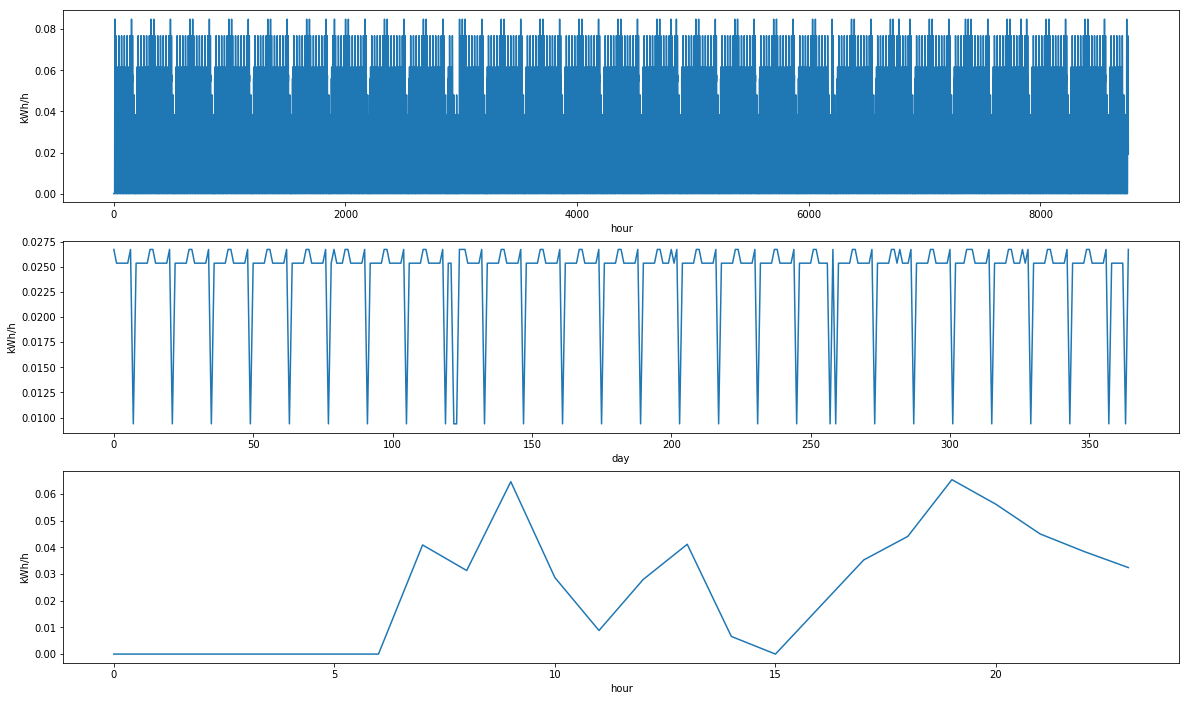

In [54]:
test1_mean_hr = np.mean(testcase1.reshape(365,24), axis=0)
test1_mean_day = np.mean(testcase1.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh1 = fig.add_subplot(311)
grh1.plot(testcase1)
grh1.set_ylabel("kWh/h")
grh1.set_xlabel("hour")

grh1_day = fig.add_subplot(312)
grh1_day.plot(test1_mean_day)
grh1_day.set_ylabel("kWh/h")
grh1_day.set_xlabel("day")

grh1_hr = fig.add_subplot(313)
grh1_hr.plot(test1_mean_hr)
grh1_hr.set_ylabel("kWh/h")
grh1_hr.set_xlabel("hour")
plt.show()



### 計算条件2

In [55]:
n_p = 4.0
A_A = 120.08
A_MR = 29.81
A_OR = 51.34

L = {"MR_installed" : "設置しない","MR_power" : None,"MR_multi" : None,"MR_dimming" : None,
     "has_OR" : "有","OR_installed" : "設置しない","OR_power" : None,"OR_dimming" : None,
     "has_NO" : "有","NO_installed" : "設置しない","NO_power" : None,"NO_sensor" : None
    }

testcase2 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)


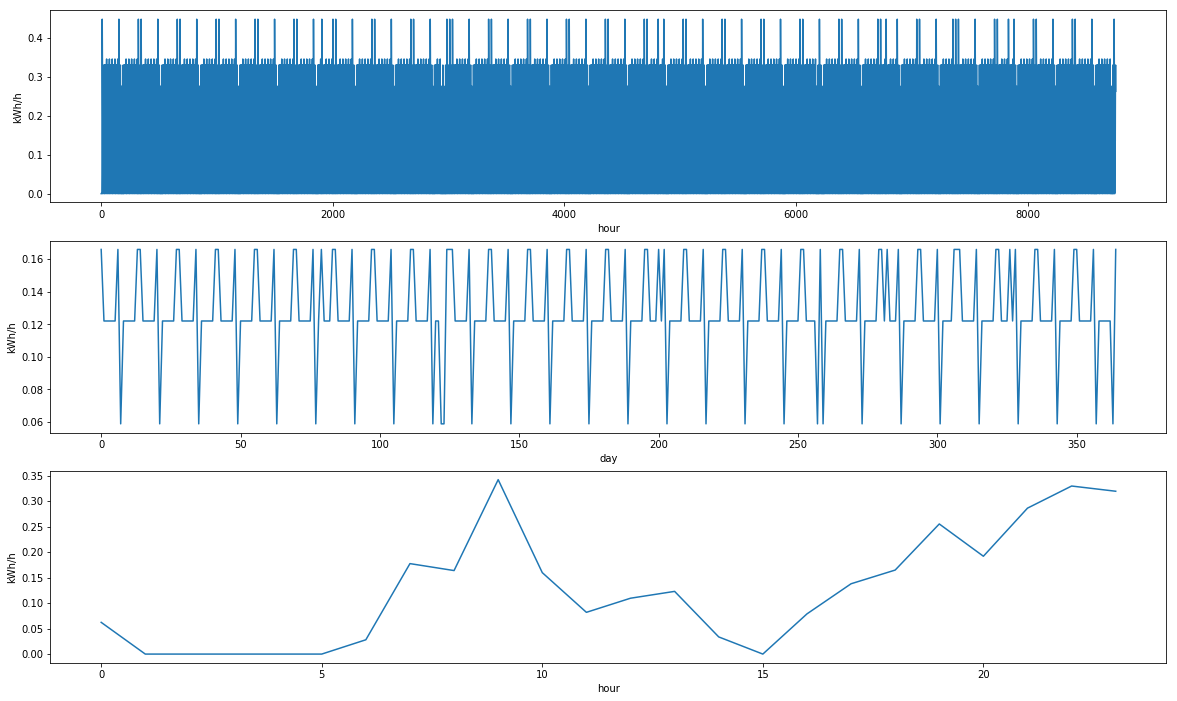

In [56]:
test2_mean_hr = np.mean(testcase2.reshape(365,24), axis=0)
test2_mean_day = np.mean(testcase2.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh2 = fig.add_subplot(311)
grh2.plot(testcase2)
grh2.set_ylabel("kWh/h")
grh2.set_xlabel("hour")

grh2_day = fig.add_subplot(312)
grh2_day.plot(test2_mean_day)
grh2_day.set_ylabel("kWh/h")
grh2_day.set_xlabel("day")

grh2_hr = fig.add_subplot(313)
grh2_hr.plot(test2_mean_hr)
grh2_hr.set_ylabel("kWh/h")
grh2_hr.set_xlabel("hour")
plt.show()

### 計算条件3

In [57]:
n_p = 4.0
A_A = 120.08
A_MR = 29.81
A_OR = 51.34

L = {"MR_installed" : "設置する","MR_power" : "すべての機器においてLEDを使用している","MR_multi" : "採用する","MR_dimming" : "採用する",
     "has_OR" : "有","OR_installed" : "設置する","OR_power" : "すべての機器においてLEDを使用している","OR_dimming" : "採用する",
     "has_NO" : "有","NO_installed" : "設置する","NO_power" : "すべての機器においてLEDを使用している","NO_sensor" : "採用する"
    }

testcase3 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)

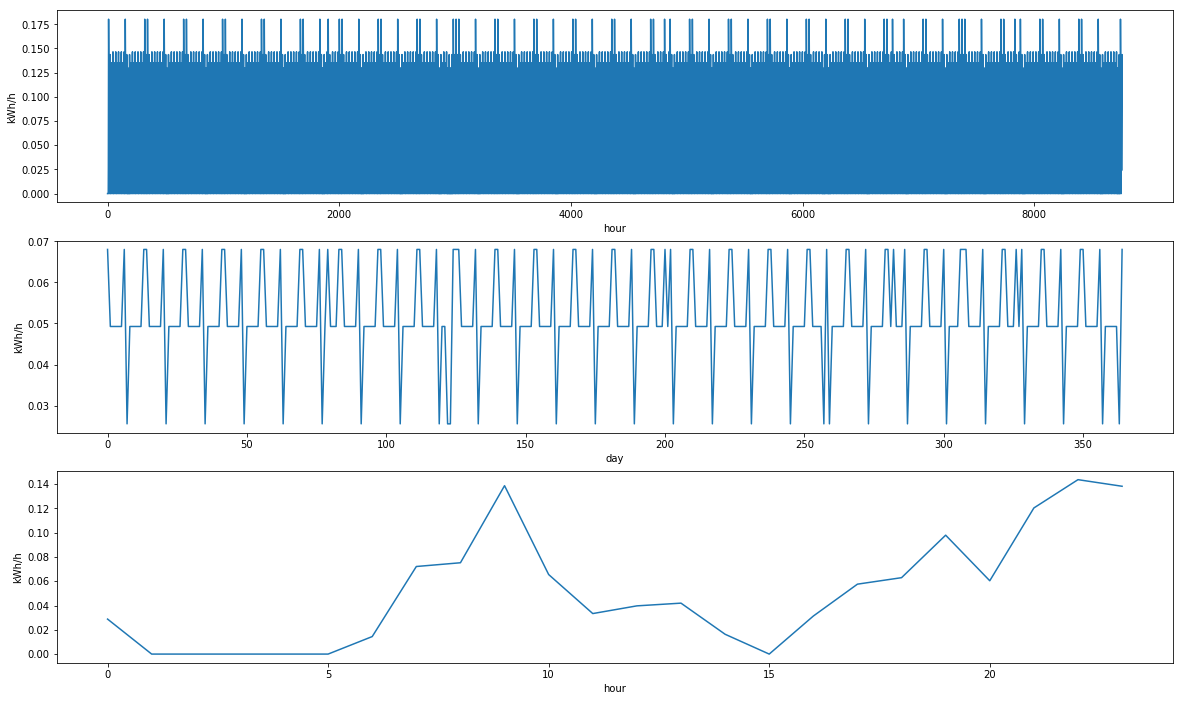

In [58]:
test3_mean_hr = np.mean(testcase3.reshape(365,24), axis=0)
test3_mean_day = np.mean(testcase3.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh3 = fig.add_subplot(311)
grh3.plot(testcase3)
grh3.set_ylabel("kWh/h")
grh3.set_xlabel("hour")

grh3_day = fig.add_subplot(312)
grh3_day.plot(test3_mean_day)
grh3_day.set_ylabel("kWh/h")
grh3_day.set_xlabel("day")

grh3_hr = fig.add_subplot(313)
grh3_hr.plot(test3_mean_hr)
grh3_hr.set_ylabel("kWh/h")
grh3_hr.set_xlabel("hour")
plt.show()

### 計算条件4

In [59]:
n_p = 4.0
A_A = 120.08
A_MR = 29.81
A_OR = 51.34

L = {"MR_installed" : "設置する","MR_power" : "すべての機器において白熱灯以外を使用している","MR_multi" : "採用しない","MR_dimming" : "採用しない",
     "has_OR" : "有","OR_installed" : "設置する","OR_power" : "すべての機器において白熱灯以外を使用している","OR_dimming" : "採用しない",
     "has_NO" : "有","NO_installed" : "設置する","NO_power" : "すべての機器において白熱灯以外を使用している","NO_sensor" : "採用しない"
    }

testcase4 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)

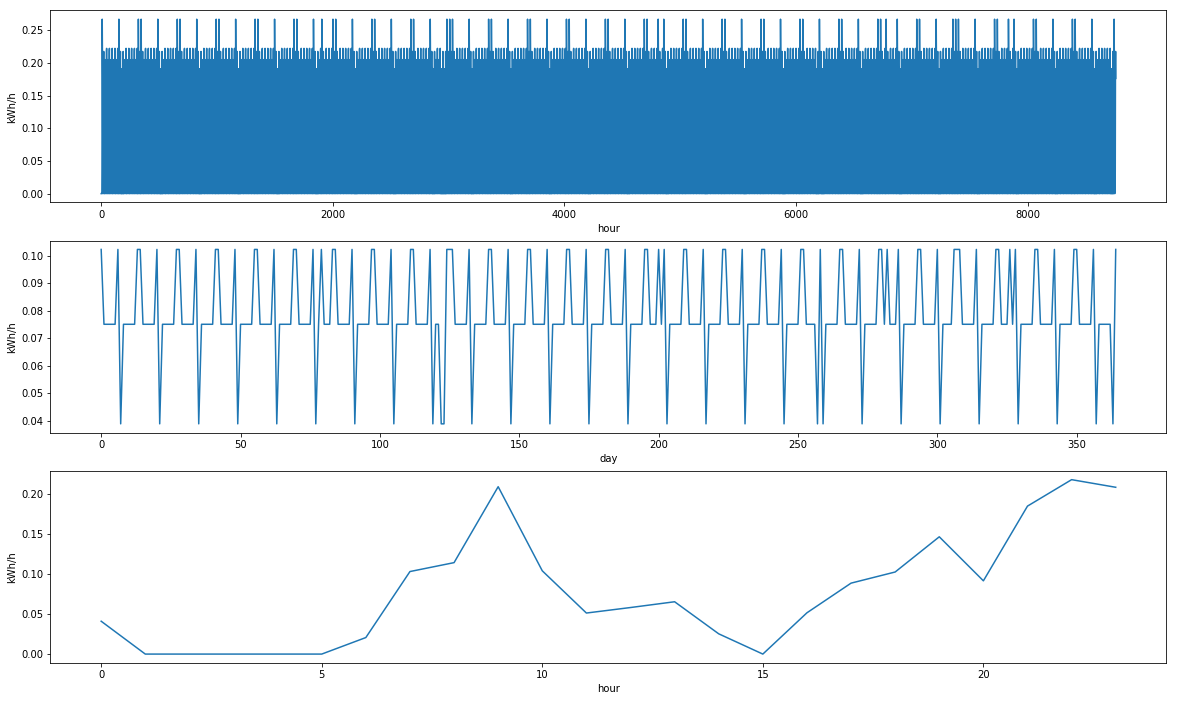

In [60]:
test4_mean_hr = np.mean(testcase4.reshape(365,24), axis=0)
test4_mean_day = np.mean(testcase4.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh4 = fig.add_subplot(311)
grh4.plot(testcase4)
grh4.set_ylabel("kWh/h")
grh4.set_xlabel("hour")

grh4_day = fig.add_subplot(312)
grh4_day.plot(test4_mean_day)
grh4_day.set_ylabel("kWh/h")
grh4_day.set_xlabel("day")

grh4_hr = fig.add_subplot(313)
grh4_hr.plot(test4_mean_hr)
grh4_hr.set_ylabel("kWh/h")
grh4_hr.set_xlabel("hour")
plt.show()

### 計算条件5

In [61]:
n_p = 4.0
A_A = 120.08
A_MR = 29.81
A_OR = 51.34

L = {"MR_installed" : "設置する","MR_power" : "いずれかの機器において白熱灯を使用している","MR_multi" : None,"MR_dimming" : "採用しない",
     "has_OR" : "有","OR_installed" : "設置する","OR_power" : "いずれかの機器において白熱灯を使用している","OR_dimming" : "採用しない",
     "has_NO" : "有","NO_installed" : "設置する","NO_power" : "いずれかの機器において白熱灯を使用している","NO_sensor" : "採用しない"
    }

testcase5 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)

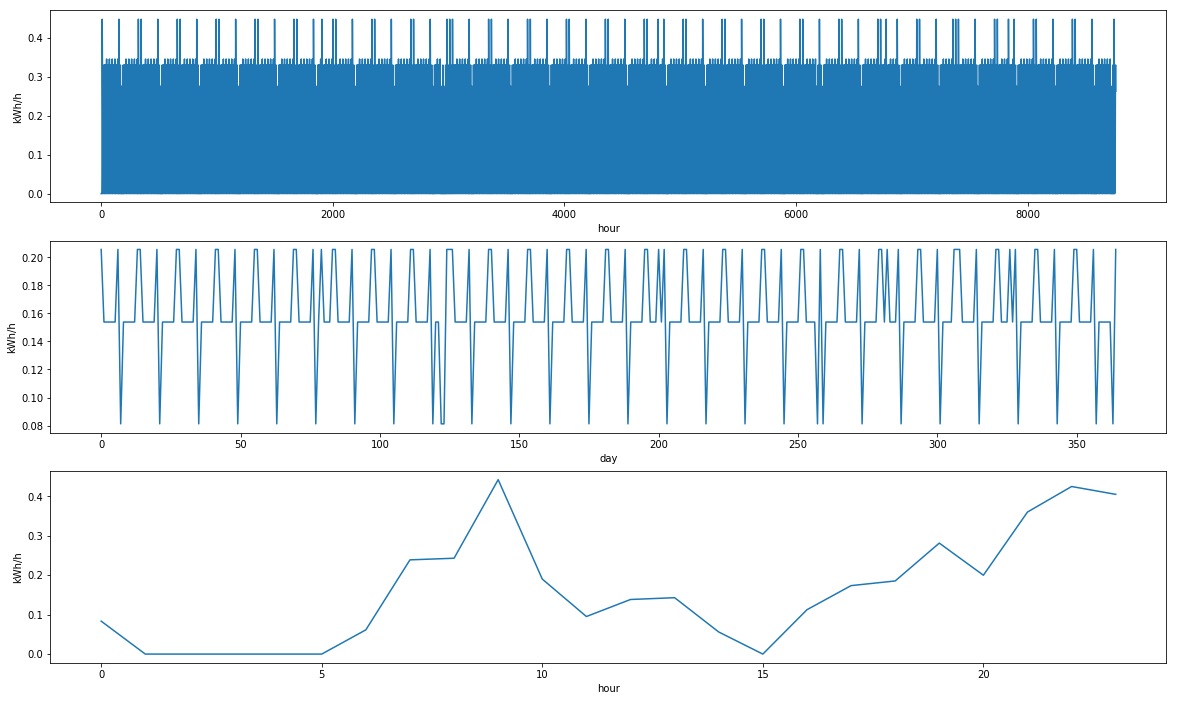

In [62]:
test5_mean_hr = np.mean(testcase5.reshape(365,24), axis=0)
test5_mean_day = np.mean(testcase5.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh5 = fig.add_subplot(311)
grh5.plot(testcase2)
grh5.set_ylabel("kWh/h")
grh5.set_xlabel("hour")

grh5_day = fig.add_subplot(312)
grh5_day.plot(test5_mean_day)
grh5_day.set_ylabel("kWh/h")
grh5_day.set_xlabel("day")

grh5_hr = fig.add_subplot(313)
grh5_hr.plot(test5_mean_hr)
grh5_hr.set_ylabel("kWh/h")
grh5_hr.set_xlabel("hour")
plt.show()

### 計算条件6

In [63]:
n_p = 3.0
A_A = 90
A_MR = 25
A_OR = 35

L = {"MR_installed" : "設置しない","MR_power" : None,"MR_multi" : None,"MR_dimming" : None,
     "has_OR" : "有","OR_installed" : "設置しない","OR_power" : None,"OR_dimming" : None,
     "has_NO" : "有","NO_installed" : "設置しない","NO_power" : None,"NO_sensor" : None
    }

testcase6 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)


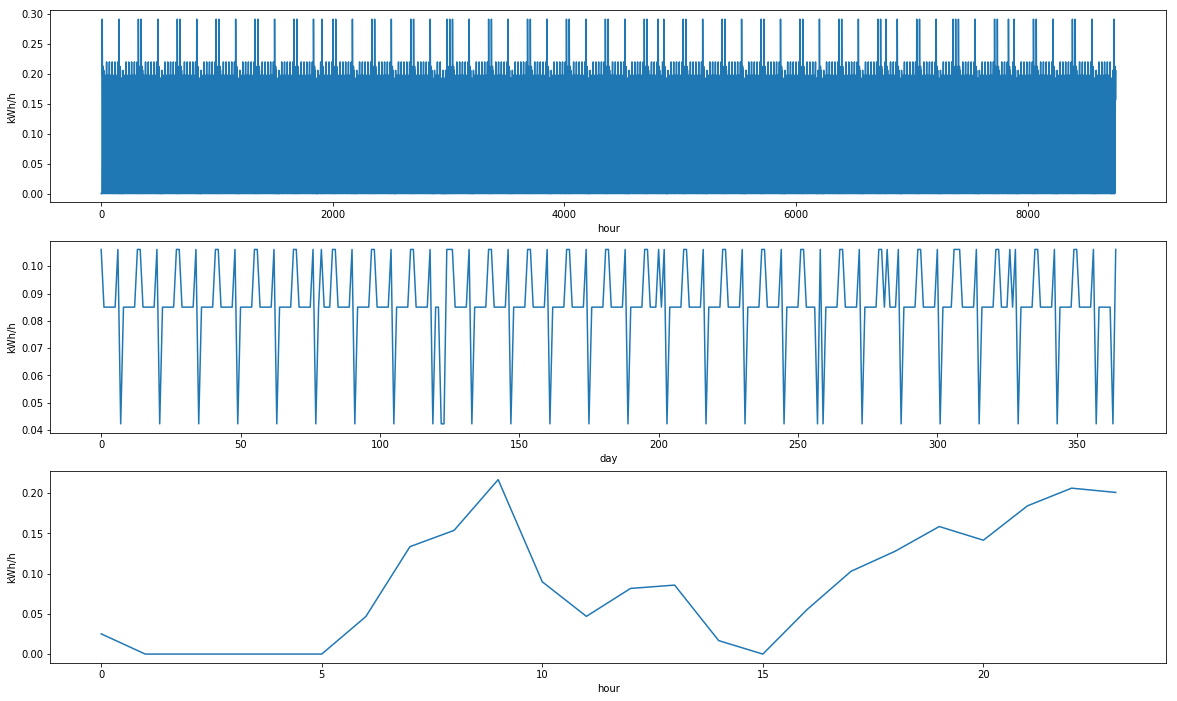

In [64]:
test6_mean_hr = np.mean(testcase6.reshape(365,24), axis=0)
test6_mean_day = np.mean(testcase6.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh6 = fig.add_subplot(311)
grh6.plot(testcase6)
grh6.set_ylabel("kWh/h")
grh6.set_xlabel("hour")

grh6_day = fig.add_subplot(312)
grh6_day.plot(test6_mean_day)
grh6_day.set_ylabel("kWh/h")
grh6_day.set_xlabel("day")

grh6_hr = fig.add_subplot(313)
grh6_hr.plot(test6_mean_hr)
grh6_hr.set_ylabel("kWh/h")
grh6_hr.set_xlabel("hour")
plt.show()

### 計算条件7

In [65]:
n_p = 2.0
A_A = 60
A_MR = 20
A_OR = 25

L = {"MR_installed" : "設置しない","MR_power" : None,"MR_multi" : None,"MR_dimming" : None,
     "has_OR" : "有","OR_installed" : "設置しない","OR_power" : None,"OR_dimming" : None,
     "has_NO" : "有","NO_installed" : "設置しない","NO_power" : None,"NO_sensor" : None
    }

testcase7 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)


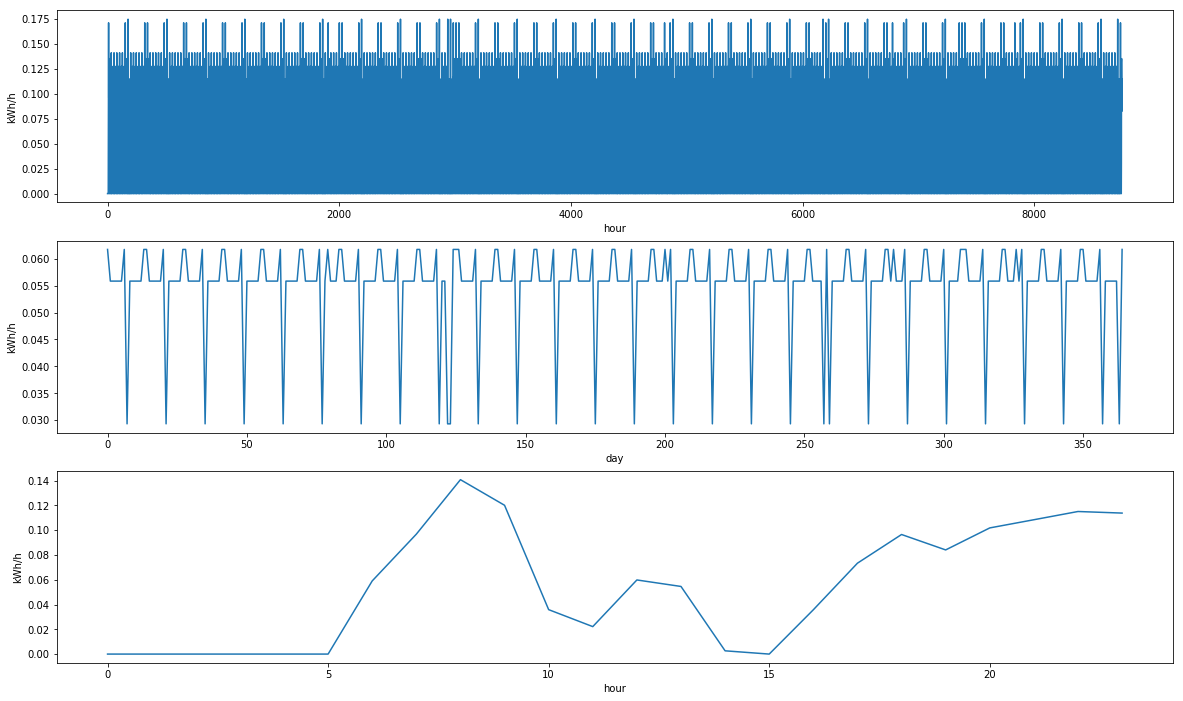

In [66]:
test7_mean_hr = np.mean(testcase7.reshape(365,24), axis=0)
test7_mean_day = np.mean(testcase7.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh7 = fig.add_subplot(311)
grh7.plot(testcase7)
grh7.set_ylabel("kWh/h")
grh7.set_xlabel("hour")

grh7_day = fig.add_subplot(312)
grh7_day.plot(test7_mean_day)
grh7_day.set_ylabel("kWh/h")
grh7_day.set_xlabel("day")

grh7_hr = fig.add_subplot(313)
grh7_hr.plot(test7_mean_hr)
grh7_hr.set_ylabel("kWh/h")
grh7_hr.set_xlabel("hour")
plt.show()

### 計算条件8

In [67]:
n_p = 1.0
A_A = 30
A_MR = 10
A_OR = 0

L = {"MR_installed" : "設置しない","MR_power" : None,"MR_multi" : None,"MR_dimming" : None,
     "has_OR" : "有","OR_installed" : "設置しない","OR_power" : None,"OR_dimming" : None,
     "has_NO" : "有","NO_installed" : "設置しない","NO_power" : None,"NO_sensor" : None
    }

testcase8 = calc_E_E_L_d_t(n_p, A_A, A_MR, A_OR, L)


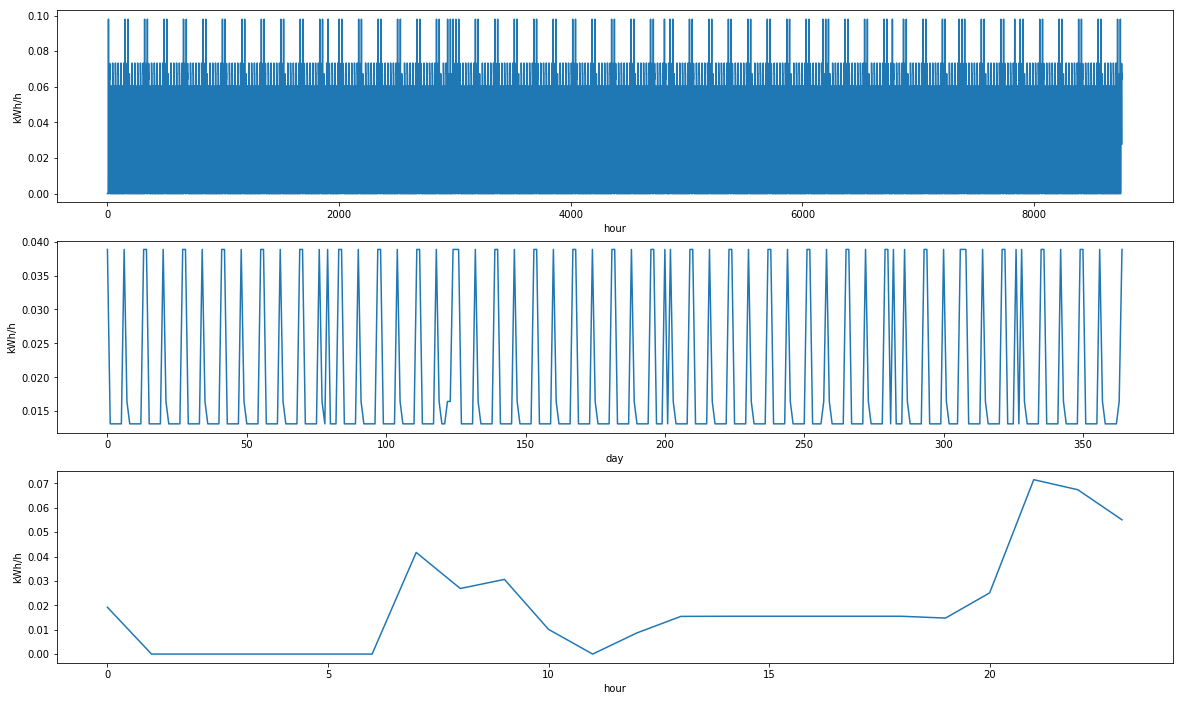

In [68]:
test8_mean_hr = np.mean(testcase8.reshape(365,24), axis=0)
test8_mean_day = np.mean(testcase8.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,12))
grh8 = fig.add_subplot(311)
grh8.plot(testcase8)
grh8.set_ylabel("kWh/h")
grh8.set_xlabel("hour")

grh8_day = fig.add_subplot(312)
grh8_day.plot(test8_mean_day)
grh8_day.set_ylabel("kWh/h")
grh8_day.set_xlabel("day")

grh8_hr = fig.add_subplot(313)
grh8_hr.plot(test8_mean_hr)
grh8_hr.set_ylabel("kWh/h")
grh8_hr.set_xlabel("hour")
plt.show()

### 比較

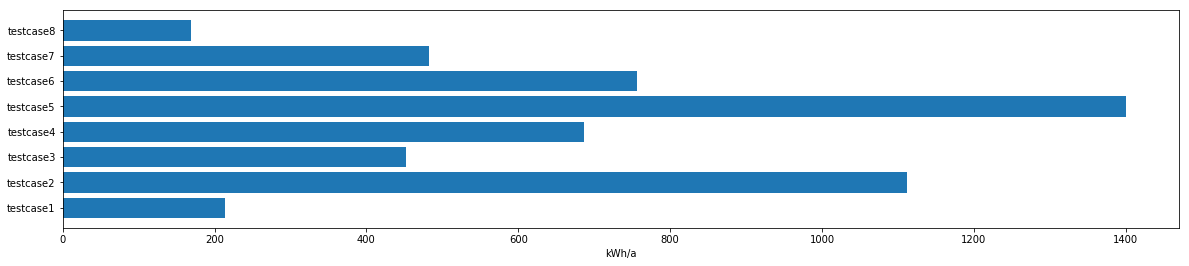

In [69]:
dat = {"testcase1":sum(testcase1),"testcase2" : sum(testcase2), "testcase3" : sum(testcase3), "testcase4" : sum(testcase4), 
       "testcase5" : sum(testcase5), "testcase6" : sum(testcase6), "testcase7" : sum(testcase7), "testcase8" : sum(testcase8)}
xx = list(dat.keys())
yy = list(dat.values())

fig = plt.figure(figsize=(20,4))
axt = fig.add_subplot(111)
axt.barh(xx,yy)
axt.set_xlabel("kWh/a")
plt.show()


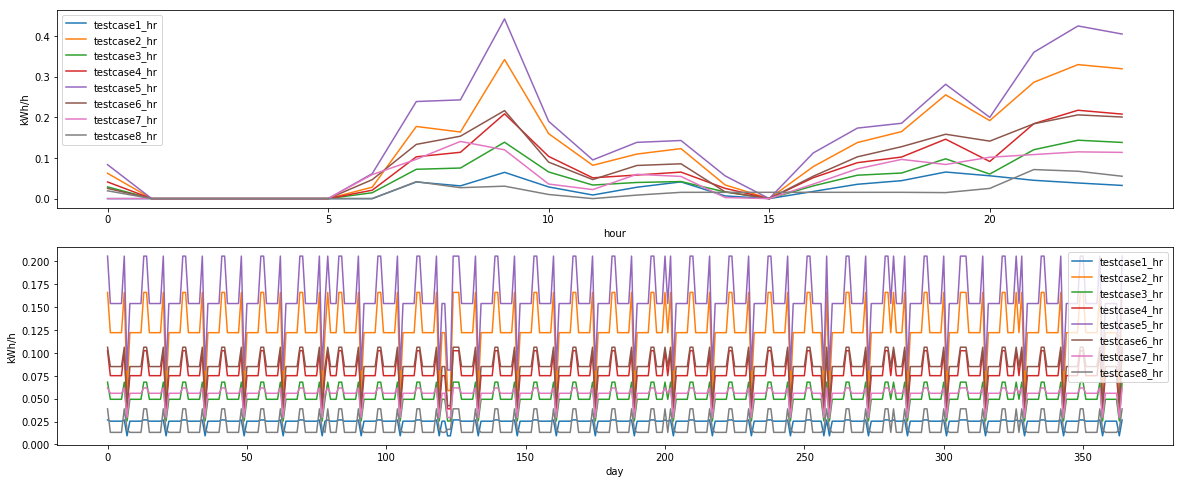

In [70]:
dat_hr = {"testcase1_hr" : test1_mean_hr, "testcase2_hr" : test2_mean_hr, "testcase3_hr" : test3_mean_hr, 
          "testcase4_hr" : test4_mean_hr, "testcase5_hr" : test5_mean_hr, "testcase6_hr" : test6_mean_hr, 
          "testcase7_hr" : test7_mean_hr, "testcase8_hr" : test8_mean_hr}
xx_hr = list(dat_hr.keys())

dat_day = {"testcase1_day" : test1_mean_day, "testcase2_day" : test2_mean_day, "testcase3_day" : test3_mean_day,
          "testcase4_day" : test4_mean_day, "testcase5_day" : test5_mean_day, "testcase6_day" : test6_mean_day,
          "testcase7_day" : test7_mean_day, "testcase8_day" : test8_mean_day}
xx_day = list(dat_day.keys())

fig = plt.figure(figsize=(20,8))
ax_hr = fig.add_subplot(211)
ax_day = fig.add_subplot(212)

for k in dat_hr.keys():
    ax_hr.plot(dat_hr[k])
    
ax_hr.legend(xx_hr)
ax_hr.set_ylabel("kWh/h")
ax_hr.set_xlabel("hour")

for k in dat_day.keys():
    ax_day.plot(dat_day[k])

ax_day.legend(xx_hr)
ax_day.set_ylabel("kWh/h")
ax_day.set_xlabel("day")
plt.show()
